In [195]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *
from matplotlib.ticker import MaxNLocator

import collections
import itertools
import tables
from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
import fbpca
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)



<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

### Enhancer-gene project pilot notebook


- mCG (not normalized, cluster level)
- RNA logTPM (normalized, cell level mean) 
- mCH normalized by global mean (normalized, cluster level)
- ATAC CPM (normalized, cluster level)


## Basic settings 

- gene annotation
- cluster annotation
- enhancers annotation
- gene features
- enhancer features

In [135]:
output_figures = '/cndd2/fangming/scf_enhancers/results/figures/191130_{}.{}'
output_results = '/cndd2/fangming/scf_enhancers/results/191130{}'

In [136]:
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/References/Annotation/gencode.vM16.annotation_genes.tsv'
df_genes = pd.read_csv(f, sep='\t')
df_genes['chrom'] = df_genes['chr'].apply(lambda x: x[3:])
df_genes = df_genes[df_genes['chrom'].isin(snmcseq_utils.get_mouse_chromosomes())]
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes['length'] = df_genes['end'] - df_genes['start']
print(df_genes.shape)
df_genes.head()

(51772, 10)


,gene_id,gene_name,chr,start,end,strand,gene_type,chrom,gid,length
0,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC,1,ENSMUSG00000102693,1069
1,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA,1,ENSMUSG00000064842,109
2,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding,1,ENSMUSG00000051951,465597
3,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene,1,ENSMUSG00000102851,479
4,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC,1,ENSMUSG00000103377,2818


In [4]:
df_genes_v2 = df_genes.groupby('gene_name').first()
df_genes_v2['chrom'] = df_genes_v2['chr'].apply(lambda x: (x[3:]))
df_genes_v2.head()

,gene_id,chr,start,end,strand,gene_type,chrom,gid,length
gene_name,,,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,7,ENSMUSG00000109644,7533
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,7,ENSMUSG00000108652,34995
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,11,ENSMUSG00000007777,3488
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,2,ENSMUSG00000086714,13694
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,11,ENSMUSG00000043644,2512


In [5]:
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/enhancers.bed'
df_enhs = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'clsts'])
df_enhs['length'] = df_enhs['end'] - df_enhs['start']
df_enhs['index'] = df_enhs.index.values
df_enhs['chrom'] = df_enhs['chr'].apply(lambda x: x[3:]) 
print(df_enhs.shape)
df_enhs.head()

(157427, 7)


,chr,start,end,clsts,length,index,chrom
0,chr1,3113717,3114035,"2_1_2,2_2_1,3_1_1,6_2_1",318,0,1
1,chr1,3211269,3211290,4_2_1,21,1,1
2,chr1,3217169,3217542,"1_2_1,2_2_1,3_1_1",373,2,1
3,chr1,3237121,3237224,4_2_1,103,3,1
4,chr1,3285379,3285395,4_2_1,16,4,1


In [6]:
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(56,)


cluster
7-2-2    L5 NP Slc17a8
7-2-1    L5 NP Slc17a8
7-1-2        L5 NP Trh
7-1-1      L6 NP Trh_1
9-1-1          L5 ET_1
Name: annotation, dtype: object

### get features 

In [7]:
import pickle as pkl
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/cluster_global_mcg.pkl'
with open(f, 'rb') as fh:
    global_mean_mcg = pkl.load(fh) 

f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/cluster_global_mch.pkl'
with open(f, 'rb') as fh:
    global_mean_mch = pkl.load(fh) 
    
print(global_mean_mcg.shape, global_mean_mch.shape)
global_mean_mcg.head()

(53,) (53,)


1-1-1     0.773445
1-2-1     0.775577
1-2-2     0.771506
10-1-1    0.833052
2-1-1     0.787401
dtype: float64

In [8]:
# gene rna
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/gene_cluster_rna_10x_v2.tsv'
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
nclsts = gene_rna_clsts.shape[1]
print(gene_rna_clsts.shape)

# remove genes with coverage in less than half of clusters
cov_mat = (gene_rna_clsts > 0)
gene_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 1000 genes 
gene_rna_clsts = gene_rna_clsts.loc[gene_conds, clsts_conds]
print(gene_rna_clsts.shape)

# logtpm normalization
gene_lengths = df_genes.set_index('gid').reindex(gene_rna_clsts.index)['length'].dropna()
# gene_lengths = gene_lengths.fillna(np.nanmean(gene_lengths))
gene_rna_clsts = snmcseq_utils.logtpm(gene_rna_clsts.loc[gene_lengths.index], gene_lengths)

print(gene_rna_clsts.shape)
gene_rna_clsts.head()

(31053, 56)
(19987, 56)
(19785, 56)


,1-1-1,1-2-1,1-2-2,10-1-1,2-1-1,2-1-2,2-2-1,2-2-2,2-2-3,2-2-4,...,7-2-1,7-2-2,8-1-1,8-1-2,8-2-1,8-3-1,8-3-2,9-1-1,9-2-1,9-2-2
ENSMUSG00000051951,1.648821,1.618817,1.559208,1.611003,1.655498,1.663785,1.635565,1.611844,1.585475,1.516051,...,1.707985,1.698712,1.643646,1.613233,1.613430,1.575986,1.585219,1.660616,1.605374,1.617597
ENSMUSG00000089699,0.288435,0.418949,0.577465,0.673580,0.382328,0.353247,0.444135,0.548070,0.446966,0.493232,...,0.306509,0.393290,0.544723,0.517334,0.589592,0.383318,0.512805,0.119607,0.144174,0.097204
ENSMUSG00000102343,0.005290,0.004943,0.004101,0.011070,0.005706,0.002832,0.006542,0.013353,0.009024,0.000000,...,0.003197,0.007033,0.003102,0.003660,0.005973,0.000000,0.000000,0.000000,0.027614,0.017796
ENSMUSG00000025900,0.002540,0.004501,0.008548,0.005472,0.002699,0.002782,0.004295,0.001772,0.007106,0.000000,...,0.001887,0.001391,0.006072,0.007160,0.004700,0.009965,0.000000,0.000928,0.004180,0.003554
ENSMUSG00000033845,0.840476,0.957715,1.126668,1.035987,0.879970,0.837957,0.927357,0.967873,0.995533,1.099504,...,0.590370,0.754549,1.012677,1.030460,1.064851,0.970612,1.253217,0.864822,1.085321,1.064788


In [9]:
# gene mch
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/gene_cluster_mch.tsv'
mc_table = pd.read_csv(f, sep='\t', index_col=0)
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/gene_cluster_ch.tsv'
c_table = pd.read_csv(f, sep='\t', index_col=0)
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage genes
# remove low coverage clusters
base_call_cutoff = 1e3
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 genes are covered in that cell type
gene_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the gene
gene_mch_c_clsts = c_table.loc[gene_cond, clst_cond]
gene_mch_mc_clsts = mc_table.loc[gene_cond, clst_cond]
print(gene_mch_c_clsts.shape)
print(gene_mch_mc_clsts.shape)

# get mcc
gene_mch_clsts = snmcseq_utils.get_mcc_lite_v2(gene_mch_c_clsts, gene_mch_mc_clsts, base_call_cutoff=base_call_cutoff)
gene_mch_clsts = gene_mch_clsts.divide(global_mean_mch.loc[gene_mch_clsts.columns.values], axis=1)

del gene_mch_c_clsts, gene_mch_mc_clsts
print(gene_mch_clsts.shape)
gene_mch_clsts.head()

(55487, 53) (55487, 53)
(34839, 53)
(34839, 53)
(34839, 53)


,1-1-1,1-2-1,1-2-2,10-1-1,2-1-1,2-1-2,2-2-1,2-2-2,2-3-1,2-3-2,...,7-1-2,7-2-1,7-2-2,8-1-1,8-1-2,8-2-1,8-3-1,9-1-1,9-2-1,9-2-2
ENSMUSG00000051951,0.585127,0.492982,0.405509,0.344345,0.509483,0.519171,0.479962,0.395845,0.664061,0.627431,...,0.556561,0.483934,0.468551,0.328460,0.312854,0.373701,0.575635,0.910935,0.810503,0.753209
ENSMUSG00000103377,0.626740,0.512025,0.425547,0.589533,0.587109,0.574752,0.596842,0.592503,0.727876,0.910802,...,1.312456,1.371550,1.124712,0.397388,0.602694,0.388527,0.532874,0.711115,1.022159,1.370970
ENSMUSG00000104017,0.579676,0.462759,0.387327,0.542550,0.721597,0.792361,0.671177,0.545284,0.811555,0.614899,...,0.747225,0.624706,0.871620,0.515409,0.554663,0.319068,0.490407,0.868590,0.659482,0.545194
ENSMUSG00000103025,0.642186,0.546094,0.462418,0.544810,0.621182,0.532478,0.493473,0.547555,0.720957,0.623816,...,0.574916,0.697269,0.578430,0.290371,0.556973,0.488555,0.492450,0.966604,0.771126,0.547465
ENSMUSG00000089699,0.635702,0.523830,0.438246,0.363464,0.511877,0.524602,0.478780,0.393545,0.720849,0.600947,...,0.561254,0.445305,0.411115,0.348041,0.322619,0.412560,0.562229,1.081310,0.760520,0.894023


In [10]:
# enhancer mcg
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/enhancer_cluster_mcg.tsv'
mc_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/enhancer_cluster_cg.tsv'
c_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage enhs
# remove low coverage clusters
base_call_cutoff = 20
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 enhs are covered in that cell type
enh_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the enh
enh_mcg_c_clsts = c_table.loc[enh_cond, clst_cond]
enh_mcg_mc_clsts = mc_table.loc[enh_cond, clst_cond]
print(enh_mcg_c_clsts.shape, enh_mcg_mc_clsts.shape)

# get mcc
enh_mcg_clsts = snmcseq_utils.get_mcc_lite_v2(enh_mcg_c_clsts, enh_mcg_mc_clsts, base_call_cutoff=base_call_cutoff)
enh_mcg_clsts = enh_mcg_clsts.divide(global_mean_mcg.loc[enh_mcg_clsts.columns.values], axis=1)
print(enh_mcg_clsts.shape)

# index
enh_mcg_clsts.index = df_enhs.set_index(['chrom', 'start', 'end']).reindex(enh_mcg_clsts.index)['index']
print(enh_mcg_clsts.shape)

del enh_mcg_c_clsts, enh_mcg_mc_clsts

print(enh_mcg_clsts.shape)
enh_mcg_clsts.head()

(157420, 53) (157420, 53)
(105628, 51) (105628, 51)
(105628, 51)
(105628, 51)
(105628, 51)


,10-1-1,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-2-2,2-3-1,2-3-2,...,7-1-2,7-2-1,7-2-2,8-1-1,8-1-2,8-2-1,8-3-1,9-1-1,9-2-1,9-2-2
index,,,,,,,,,,,,,,,,,,,,,
0,0.643887,0.732653,0.633566,0.699519,0.218281,0.211427,0.147583,0.645765,0.313127,0.743879,...,0.937336,0.641494,0.966029,0.648299,0.643623,0.636010,0.645810,0.684416,0.589149,0.681204
15,0.375280,0.177924,0.089956,0.028804,0.070994,0.033679,0.014298,0.376374,0.205062,0.391675,...,1.060826,0.373885,1.052512,0.377851,0.375125,0.059286,0.376400,0.411601,0.141832,0.397029
19,1.060055,1.226855,1.142389,1.142384,1.198952,1.216785,1.211176,1.063147,1.264551,1.252849,...,1.050620,1.056115,1.056197,1.067318,1.059619,1.140114,1.063220,1.126779,1.276490,1.121491
24,0.726844,0.387875,0.146809,0.295167,0.093758,0.032950,0.123509,0.728963,0.390127,0.653660,...,1.117860,0.724142,1.080291,0.731824,0.726545,0.479934,0.729014,1.203051,1.063742,0.768968
25,1.050355,1.200712,1.152963,1.092275,1.097212,1.032115,1.089244,1.178825,1.197996,1.231614,...,1.161954,1.114862,1.063144,1.141484,1.071590,1.071433,1.075231,1.219254,1.253281,1.227643


In [11]:
# enhancer atac
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/enhancer_cluster_atac.tsv'
enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=[0, 1, 2])
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

nclsts = enh_atac_clsts.shape[1]
print(enh_atac_clsts.shape)

# remove enhs with coverage in less than half of clusters
# remove clusters with low coverage
cov_mat = (enh_atac_clsts > 0)
enh_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 10000 enhs 
enh_atac_clsts = enh_atac_clsts.loc[enh_conds, clsts_conds]
print(enh_atac_clsts.shape)

# logtpm normalization
enh_lengths = df_enhs.copy()
enh_lengths['start'] = df_enhs['start'] - 1000
enh_lengths['end'] = df_enhs['end'] + 1000
enh_lengths['length'] = df_enhs['length'] + 2*1000 # 1kb flanking
enh_lengths = enh_lengths.set_index(['chr', 'start', 'end']).reindex(enh_atac_clsts.index) 

enh_atac_clsts = snmcseq_utils.logtpm(enh_atac_clsts, enh_lengths['length'])
enh_atac_clsts.index = enh_lengths['index']
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

(157427, 56)
(157427, 56)
(108329, 53)
(108329, 53)


,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-2-2,2-2-3,2-2-4,2-3-1,...,7-1-2,7-2-1,7-2-2,8-1-1,8-1-2,8-2-1,8-3-1,9-1-1,9-2-1,9-2-2
index,,,,,,,,,,,,,,,,,,,,,
1,0.504050,0.771592,0.781443,0.768040,0.738191,0.718340,0.0,1.312203,0.0,0.592608,...,0.000000,0.701196,0.000000,0.000000,1.917277,1.022538,0.0,0.976359,1.911428,0.000000
2,0.585580,0.807348,1.028111,0.975959,0.807059,0.988782,0.0,0.000000,0.0,0.744270,...,0.000000,0.552839,0.000000,0.919956,0.000000,1.236468,0.0,0.227122,0.000000,0.000000
3,0.422729,0.578441,0.666207,0.607152,0.619831,0.604050,0.0,0.000000,0.0,0.579814,...,0.670744,0.293845,1.196879,0.000000,0.000000,1.006935,0.0,0.335026,0.000000,0.000000
4,0.515508,0.720244,0.547661,0.598437,0.791803,0.729136,0.0,0.000000,0.0,0.644238,...,0.000000,0.848406,0.938804,0.982835,0.000000,1.303468,0.0,0.417865,0.000000,0.000000
5,0.884009,1.074242,1.063965,1.059467,0.898441,1.026606,0.0,1.528502,0.0,0.876308,...,0.871406,0.429648,0.000000,0.914367,0.000000,1.230481,0.0,0.807286,0.000000,1.768774


### Shared enhancers, shared genes, shared clusters, and nan check

In [12]:
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

shared_genes = np.intersect1d(gene_rna_clsts.index.values, gene_mch_clsts.index.values)
shared_enhs = np.intersect1d(enh_mcg_clsts.index.values, enh_atac_clsts.index.values) 
shared_clusters = np.array(list(set(gene_rna_clsts.columns.tolist())
                              & set(gene_mch_clsts.columns.tolist())
                              & set(enh_mcg_clsts.columns.tolist())
                              & set(enh_atac_clsts.columns.tolist())
                        ))
print(shared_genes.shape, shared_enhs.shape, shared_clusters.shape)
print(shared_genes[:2])
print(shared_enhs[:2])
print(shared_clusters[:2])


(19785, 56)
(34839, 53)
(105628, 51)
(108329, 53)
(19413,) (78440,) (50,)
['ENSMUSG00000000001' 'ENSMUSG00000000003']
[15 19]
['9-1-1' '5-2-2']


In [13]:
gene_rna_clsts = gene_rna_clsts.loc[shared_genes, shared_clusters]
gene_mch_clsts = gene_mch_clsts.loc[shared_genes, shared_clusters]
enh_mcg_clsts = enh_mcg_clsts.loc[shared_enhs, shared_clusters]
enh_atac_clsts = enh_atac_clsts.loc[shared_enhs, shared_clusters]
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

(19413, 50)
(19413, 50)
(78440, 50)
(78440, 50)


In [14]:
print(gene_rna_clsts.isnull().sum().sum())
print(gene_mch_clsts.isnull().sum().sum())
print(enh_mcg_clsts.isnull().sum().sum())
print(enh_atac_clsts.isnull().sum().sum())

0
0
0
0


### Get nearest gene info for each region

In [15]:
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str})
regions_info = regions_info.iloc[:, [0,1,2,3,8,9,11]] 
regions_info.columns = ['chr', 'start', 'end', 'clusters', 'gene_id', 'gene_name', 'distance']
regions_info = pd.merge(regions_info, df_enhs, on=['chr', 'start', 'end']).sort_values('index')
# regions_info = regions_info.groupby('index').first().reset_index()

print(regions_info.shape)
regions_info.head()


(157427, 11)


,chr,start,end,clusters,gene_id,gene_name,distance,clsts,length,index,chrom
0,chr1,3113717,3114035,"2_1_2,2_2_1,3_1_1,6_2_1",ENSMUSG00000051951.5,Xkr4,557464,"2_1_2,2_2_1,3_1_1,6_2_1",318,0,1
1,chr1,3211269,3211290,4_2_1,ENSMUSG00000051951.5,Xkr4,460209,4_2_1,21,1,1
2,chr1,3217169,3217542,"1_2_1,2_2_1,3_1_1",ENSMUSG00000051951.5,Xkr4,453957,"1_2_1,2_2_1,3_1_1",373,2,1
3,chr1,3237121,3237224,4_2_1,ENSMUSG00000051951.5,Xkr4,434275,4_2_1,103,3,1
4,chr1,3285379,3285395,4_2_1,ENSMUSG00000051951.5,Xkr4,386104,4_2_1,16,4,1


## Correlation  

In [16]:
# select common clusters
# clusters_selected = np.array(list(clst_annot.keys())) 

# clusters_selected = np.intersect1d(gene_rna_clsts.columns.values, enh_mcg_clsts.columns.values)
# clusters_selected_labels = np.array([str(clst)+" "+clst_annot[clst] for clst in clusters_selected])
# clusters_selected_labels

#### Length of enhancers 

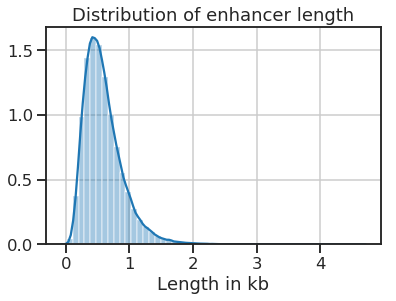

In [17]:
lens = df_enhs.loc[shared_enhs, 'length']
fig, ax = plt.subplots()
sns.distplot(lens.values/1000, ax=ax)
ax.set_xlabel('Length in kb')
ax.set_title('Distribution of enhancer length')
output_name = 'Enhancer length distribution' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()


In [18]:
# full correlation

# gene 
_x_features = shared_genes 
_X = gene_rna_clsts.values
# # enhancer
_y_features = shared_enhs
_Y = enh_mcg_clsts.values 
print(_X.shape, _Y.shape)

# row genes_list 
def get_tss(row):
    if row['strand'] == '+':
        return row['start']
    elif row['strand'] == '-':
        return row['end']
genes_list = df_genes.set_index('gid').reindex(shared_genes).reset_index().copy()
genes_list['chrom'] = genes_list['chr'].apply(lambda x: x[len('chr'):])
genes_list['tss'] = genes_list.apply(get_tss, axis=1)

# row ens_list
ens_list = df_enhs.set_index('index').loc[shared_enhs].reset_index()
ens_list['center'] = ens_list[['start', 'end']].mean(axis=1).astype(int)

print(ens_list.shape, genes_list.shape)
genes_list.head()

(19413, 50) (78440, 50)
(78440, 8) (19413, 11)


,gid,gene_id,gene_name,chr,start,end,strand,gene_type,chrom,length,tss
0,ENSMUSG00000000001,ENSMUSG00000000001.4,Gnai3,chr3,108107280,108146146,-,protein_coding,3,38866,108146146
1,ENSMUSG00000000003,ENSMUSG00000000003.15,Pbsn,chrX,77837901,77853623,-,protein_coding,X,15722,77853623
2,ENSMUSG00000000028,ENSMUSG00000000028.14,Cdc45,chr16,18780447,18811987,-,protein_coding,16,31540,18811987
3,ENSMUSG00000000037,ENSMUSG00000000037.16,Scml2,chrX,161117193,161258213,+,protein_coding,X,141020,161117193
4,ENSMUSG00000000049,ENSMUSG00000000049.11,Apoh,chr11,108343354,108414396,+,protein_coding,11,71042,108343354


In [19]:
# more than 15 mins for ~500,000 enhancers

# tss and enhancer center: 500KB ~ 2KB
# to_evals - ens, gene, val, dist

_X_ranks = snmcseq_utils.rank_rows(_X)
_Y_ranks = snmcseq_utils.rank_rows(_Y)

KB = 1000
window_size = 2000*KB # (+/- 1Mb)
inner_window_size = 4*KB #(+/- 2kb)
to_evals = [] 

ti = time.time()
# ens, gene
for idx, gene in genes_list.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals.append((gene['gid'], ens))
to_evals = pd.DataFrame(to_evals, columns=['gene', 'ens'])

output_toevals = output_results.format('to_evals.tsv')
print(to_evals.shape)
to_evals.head()
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)

0 0.0055582523345947266


/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py:461: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  srs_gsize = pd.read_table(genome_size_fname, header=None, index_col=0, squeeze=True)


1000 18.29420757293701
2000 37.76115322113037
3000 57.498762130737305
4000 77.59629416465759
5000 96.99377489089966
6000 117.16137146949768
7000 136.5834984779358
8000 154.639057636261
9000 173.70706939697266
10000 192.37566542625427
11000 211.7082483768463
12000 230.10961437225342
13000 249.10070753097534
14000 266.71480441093445
15000 285.7254059314728
16000 305.5126042366028
17000 324.9162836074829
18000 344.84566736221313
19000 362.9639582633972
(1526116, 2)


In [20]:
f = output_results.format('to_evals.tsv')
to_evals = pd.read_csv(f, sep="\t")
print(to_evals.shape)
to_evals.head()

(1526116, 2)


,gene,ens
0,ENSMUSG00000000001,30035
1,ENSMUSG00000000001,30037
2,ENSMUSG00000000001,30038
3,ENSMUSG00000000001,30040
4,ENSMUSG00000000001,30041


In [21]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals['ens'].values)
to_evals['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals['dist'] = np.abs(ens_list.set_index('index').loc[to_evals['ens'].values, 'center'].values 
                        - genes_list.set_index('gid').loc[to_evals['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals.head()

4.860250949859619


,gene,ens,val,dist
0,ENSMUSG00000000001,30035,-0.157263,995118
1,ENSMUSG00000000001,30037,-0.358175,987167
2,ENSMUSG00000000001,30038,0.124610,985779
3,ENSMUSG00000000001,30040,-0.510012,969326
4,ENSMUSG00000000001,30041,-0.008211,958828


In [22]:
# shuffle

ti = time.time()
np.random.seed(0)

to_evals_shuffled = [] 
# shuffle gene_name label
genes_list_shuffle = genes_list.copy()
# genes_list_shuffle['gene_name'] = np.random.permutation(genes_list_shuffle['gene_name'].values)
genes_list_shuffle['gid'] = np.random.permutation(genes_list_shuffle['gid'].values)

# ens, gene
for idx, gene in genes_list_shuffle.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals_shuffled.append((gene['gid'], ens))
to_evals_shuffled = pd.DataFrame(to_evals_shuffled, columns=['gene', 'ens'])

print(len(to_evals_shuffled))

f = output_results.format('to_evals_shuffled.tsv')
print(to_evals_shuffled.shape)
to_evals_shuffled.to_csv(f, sep="\t", header=True, index=False)
to_evals_shuffled.head()

0 0.011966466903686523


/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py:461: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  srs_gsize = pd.read_table(genome_size_fname, header=None, index_col=0, squeeze=True)


1000 19.065916061401367
2000 38.10927724838257
3000 58.06904220581055
4000 77.17703247070312
5000 96.13471484184265
6000 115.53132247924805
7000 135.89084672927856
8000 154.92766427993774
9000 174.5250482559204
10000 194.6389045715332
11000 214.02457475662231
12000 233.45318174362183
13000 253.20869779586792
14000 273.1023635864258
15000 292.51218843460083
16000 312.1290831565857
17000 330.35858821868896
18000 348.8633906841278
19000 368.60235571861267
1526116
(1526116, 2)


,gene,ens
0,ENSMUSG00000114378,30035
1,ENSMUSG00000114378,30037
2,ENSMUSG00000114378,30038
3,ENSMUSG00000114378,30040
4,ENSMUSG00000114378,30041


In [23]:
f = output_results.format('to_evals_shuffled.tsv')
to_evals_shuffled = pd.read_csv(f, sep="\t")
print(to_evals_shuffled.shape)
to_evals_shuffled.head()

(1526116, 2)


,gene,ens
0,ENSMUSG00000114378,30035
1,ENSMUSG00000114378,30037
2,ENSMUSG00000114378,30038
3,ENSMUSG00000114378,30040
4,ENSMUSG00000114378,30041


In [24]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals_shuffled['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals_shuffled['dist'] = np.abs(ens_list.set_index('index').loc[to_evals_shuffled['ens'].values, 'center'].values 
                        - genes_list_shuffle.set_index('gid').loc[to_evals_shuffled['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals_shuffled.head()

2.4069504737854004


,gene,ens,val,dist
0,ENSMUSG00000114378,30035,0.004274,995118
1,ENSMUSG00000114378,30037,-0.376615,987167
2,ENSMUSG00000114378,30038,0.195870,985779
3,ENSMUSG00000114378,30040,-0.406483,969326
4,ENSMUSG00000114378,30041,0.034142,958828


In [25]:
# mean within a distance bin
n = 100
_dist = np.linspace(0, window_size/(2*KB), n)
_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val']
_mval = _tmp.mean()
_stdval = _tmp.std()
_sizes = _tmp.size()
print(_dist.shape, _mval.shape)

(100,) (100,)


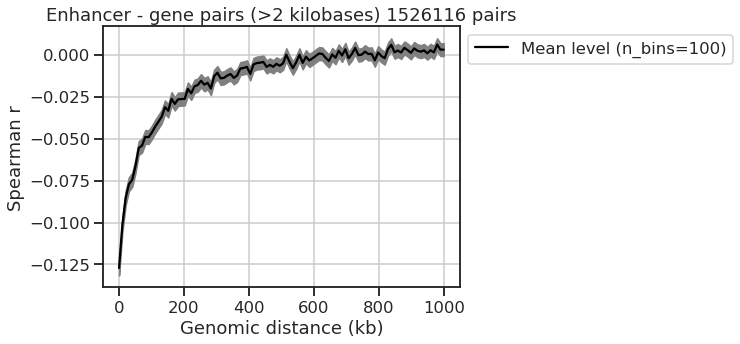

In [26]:
scale = 0.8
fig, ax = plt.subplots(figsize=(8*scale,6*scale))
x = to_evals['dist'].values/1000, 
y = to_evals['val'].values, 

yerr = 1.96*_stdval/np.sqrt(_sizes)
ax.plot(
    _dist, _mval,
    # yerr=yerr,
    '-',
    c='black',
    label='Mean level (n_bins={})'.format(n),
    markersize=5,
    # capsize=3,
)

ax.fill_between(_dist, _mval-yerr, _mval+yerr, color='gray')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Enhancer - gene pairs (>2 kilobases) {} pairs'.format(len(to_evals)))
output_name = 'line_distance_vs_spearmanr' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()
    


### Statistical evaluation 
compute local FDR: 
- histogram -> density estimation (interpolate) -> cdf (cumsum), ratio of cdf
- quantile ranking (cdf) -> interpolate -> ratio of cdf

#### Setting up 

In [27]:
def bin_mean(x, y, bins):
    """Bin x according to bins, return bins, y_mean
    """
    # bin _x and mean_y
    _df = pd.DataFrame()
    _df['bin'] = np.digitize(_x, bins)
    _df['_y'] = _y
    _y_mean = _df.groupby('bin').mean()['_y']
    
    return bins[_y_mean.index], _y_mean.values

def fdr(x, x_bck, y_bck, x_fr, y_fr):
    """
    """
    return (np.interp(x, x_bck, y_bck))/(np.interp(x, x_fr, y_fr)+1e-6)

def pvalue(x, x_bck, y_bck):
    """
    """
    return np.interp(x, x_bck, y_bck)


In [28]:
regions = df_enhs # back compatibility

In [29]:
# randomly sample many genes and enhancers
ti = time.time()

p = 0.05
np.random.seed(0)
_y_selected_idx = np.arange(len(_y_features))[np.random.rand(len(_y_features))<p]
_x_selected_idx = np.arange(len(_x_features))

_x_selected_features = _x_features[_x_selected_idx]
_y_selected_features = _y_features[_y_selected_idx]

# same chrom or not
x_chroms = df_genes.set_index('gid').reindex(_x_selected_features)['chrom'].values
y_chroms = regions.set_index('index').reindex(_y_selected_features)['chrom'].values

corr = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], _Y[_y_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr_cis_mask = np.zeros_like(corr)
for i, x_chrom in enumerate(x_chroms):
    for j, y_chrom in enumerate(y_chroms):
        if x_chrom == y_chrom:
            corr_cis_mask[i,j] = 1
            
corr_cis = corr[corr_cis_mask.nonzero()]
# corr_noncis = corr[(~corr_cis_mask.astype(bool)).nonzero()] 
print(time.time()-ti)

17.40762686729431


In [198]:
labels = ['All',
          'Same chrom',
        '<500kb',
        '<200kb',
        '<100kb',
        '<100kb shuffled',
         ]

corr_tracks = [corr.flatten(),
       corr_cis,
       to_evals.loc[to_evals['dist']<=500*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val'].values,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val'].values,
      ]

subsample_rates = [0.01,
                  0.1,
                  1,
                  1,
                  1,
                  1,
                 ]

np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]

colors = ['black', 'gray', 'C0', 'C2', 'C1', 'C7']

In [31]:
# FDR

bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks[0])
_y = np.arange(len(_x))/len(_x)
x_smooth_bck, y_smooth_bck = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck, y_smooth_bck)
to_evals['pvalues'] = pvalue(to_evals['val'].values, x_smooth_bck, y_smooth_bck)

# fore-ground - 2
fdrs = []
for corr_track, track_name in zip(corr_tracks[2:5], labels[2:5]):
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
    fdrs.append(fdr(bins_eval, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr{}'.format(track_name)] = fdr(to_evals['val'].values, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0)

In [32]:
to_evals.head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
0,ENSMUSG00000000001,30035,-0.157263,995118,0.235784,0.813497,0.718179,0.655296
1,ENSMUSG00000000001,30037,-0.358175,987167,0.063154,0.658572,0.523850,0.443946
2,ENSMUSG00000000001,30038,0.124610,985779,0.683095,0.948715,0.917200,0.894660
3,ENSMUSG00000000001,30040,-0.510012,969326,0.016277,0.518071,0.375003,0.293285
4,ENSMUSG00000000001,30041,-0.008211,958828,0.463709,0.898146,0.840348,0.799440


In [33]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val'].values,
})

res_num_sig = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck, y_smooth_bck, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.20)
    res_num_sig.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig = pd.DataFrame(res_num_sig)
print(res_num_sig.shape)
res_num_sig.head()

(5, 2)


,num_sig,track_name
0,4027,2-100
1,94,100-200
2,3,200-300
3,0,300-400
4,3,400-500


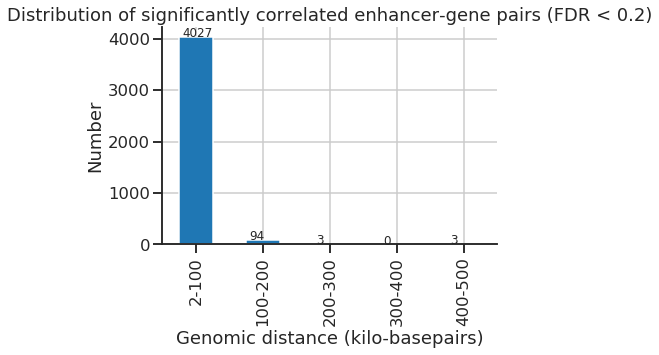

In [34]:
output_name = 'FDR_number'
fig, ax = plt.subplots()
res_num_sig.plot.bar(ax=ax, legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig['track_name'].values)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

#### Test individual pairs

In [35]:
to_evals.head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
0,ENSMUSG00000000001,30035,-0.157263,995118,0.235784,0.813497,0.718179,0.655296
1,ENSMUSG00000000001,30037,-0.358175,987167,0.063154,0.658572,0.523850,0.443946
2,ENSMUSG00000000001,30038,0.124610,985779,0.683095,0.948715,0.917200,0.894660
3,ENSMUSG00000000001,30040,-0.510012,969326,0.016277,0.518071,0.375003,0.293285
4,ENSMUSG00000000001,30041,-0.008211,958828,0.463709,0.898146,0.840348,0.799440


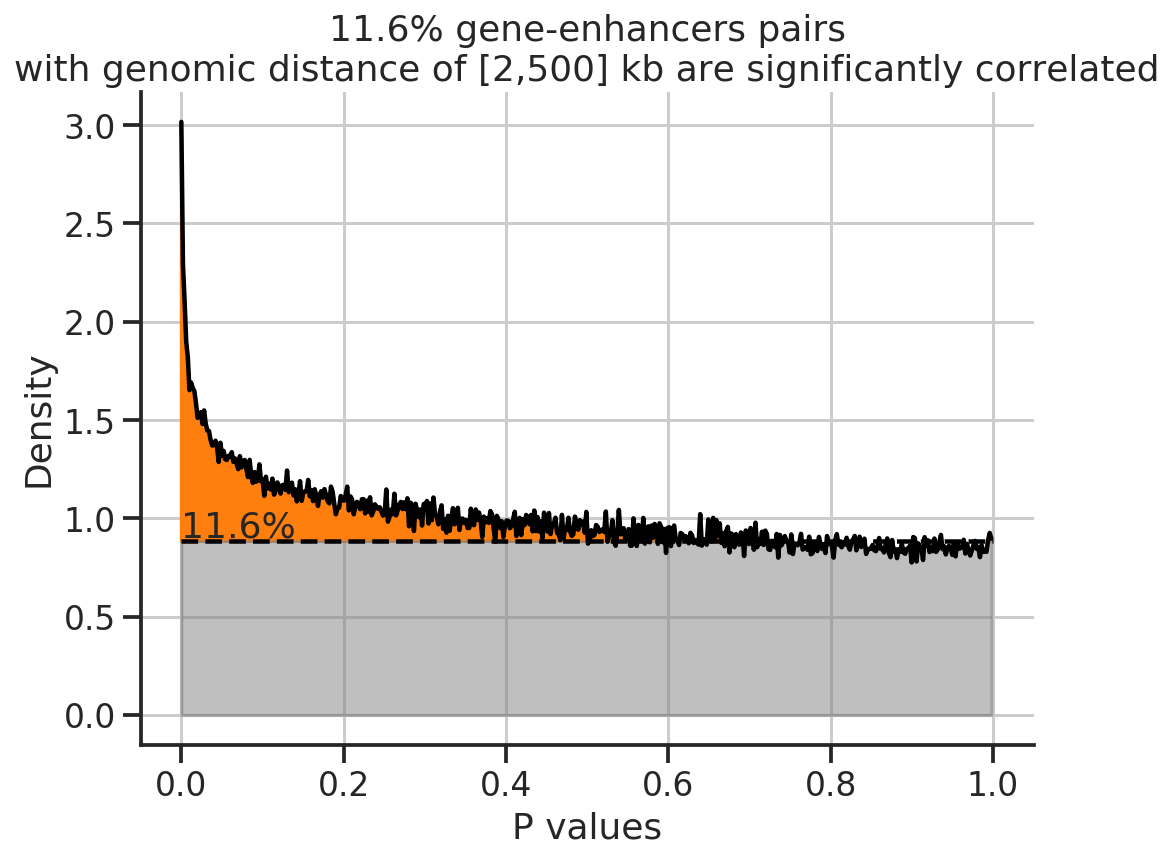

In [204]:
# plot pvalues
output_name = 'fraction-of-h1-one-example'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues'].sort_values().values
bin_n = 500
bin_edges = np.linspace(0, 1, bin_n)
bin_width = 1.0/bin_n
bin_counts, bin_edges = np.histogram(y, bin_edges)
y_norm = bin_counts/(bin_width*bin_counts.sum())
null_level = y_norm[-int(0.50*bin_n):].mean()
# frac_tp = np.sum(np.maximum(y_norm-null_level, 0)*bin_width)
frac_tp = 1 - null_level 


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color='C1')
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='grey')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)
sns.despine(ax=ax)


ax.set_xlabel('P values')
ax.set_ylabel('Density')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [37]:
frac_tps = []
num_tps = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues'].values
    bin_n = 500
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = y_norm[-int(0.50*bin_n):].mean()
    frac_tp = 1 - null_level 
    frac_tps.append(frac_tp)
    num_tps.append(len(y))


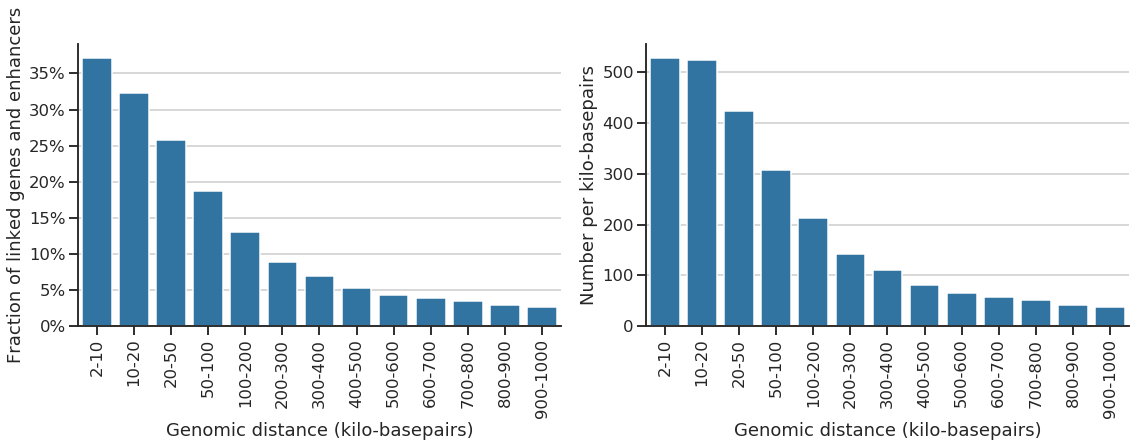

In [38]:
output_name = 'fraction-of-h1-summary'

df_plot = pd.DataFrame(np.vstack([dists_kb, frac_tps]).T, columns=['x', 'y'])
dists_kb_plot = np.hstack([[2], dists_kb])
df_plot['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot['num'] = np.array(num_tps)*np.array(frac_tps)
df_plot['num_norm'] = df_plot['num']/df_plot['length']

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True)
ax = axs[0]
sns.barplot(x='x_formatted', y='y', data=df_plot, color='C0', ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Fraction of linked genes and enhancers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 
sns.despine(ax=ax)

ax = axs[1]
sns.barplot(x='x_formatted', y='num_norm', data=df_plot, color='C0', ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Number per kilo-basepairs')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax)

fig.tight_layout()
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()



In [72]:
# significant ones
sig_cond = (
    ((to_evals['fdr<100kb']<0.05) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr<200kb']<0.05) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr<500kb']<0.05) & (to_evals['dist']<500*KB))
)

top_sig = to_evals[sig_cond].sort_values(['val']) #.head(30)
top_sig['gene_name'] = gid_to_name.loc[top_sig['gene'].values].values

# top_sig = to_evals[(to_evals['fdr-200k']<0.05) & (to_evals['dist']<200*KB)].sort_values(['fdr-200k', 'val']) #.head(30)
# top_sig = to_evals[(to_evals['fdr-500k']<0.05) & (to_evals['dist']<500*KB)].sort_values(['fdr-100k', 'val']) #.head(30)

top_sig = pd.merge(top_sig, ens_list, left_on='ens', right_on='index')
top_sig_genes = top_sig.groupby('gene').size().sort_values(ascending=False).index.values
top_sig_ens = top_sig.groupby('ens').size().sort_values(ascending=False).index.values

n_pair, n_enh, n_gene = len(top_sig), len(top_sig_ens), len(top_sig_genes)
print('{} significantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair, n_enh, len(_y_features), n_gene, len(_x_features)) 
     )
top_sig.head()

319 significantly correlated enhancer-gene pairs
297/78440 enhancers 204/19413 genes


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,chr,start,end,clsts,length,chrom,center
0,ENSMUSG00000028944,44640,-0.910492,15219,0.0,0.0,0.0,0.0,Prkag2,44640,chr5,25084486,25086360,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",1874,5,25085423
1,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,chr8,84763913,84767261,"1_2_1,4_1_1,4_2_1",3348,8,84765587
2,ENSMUSG00000029094,45230,-0.898103,10929,0.0,0.0,0.0,0.0,Afap1,45230,chr5,35902446,35906050,5_1_2,3604,5,35904248
3,ENSMUSG00000057880,134049,-0.891188,11744,0.0,0.0,0.0,0.0,Abat,134049,chr16,8523966,8526381,"5_1_1,5_1_2,5_3_1,6_1_1,6_1_2,6_2_1,6_4_2,6_5_1",2415,16,8525173
4,ENSMUSG00000106515,33115,-0.888980,2204,0.0,0.0,0.0,0.0,Gm30382,33115,chr3,149442486,149443709,"1_1_1,1_2_1,3_1_1,3_2_1,4_1_1,4_2_1",1223,3,149443097


#### Plots 

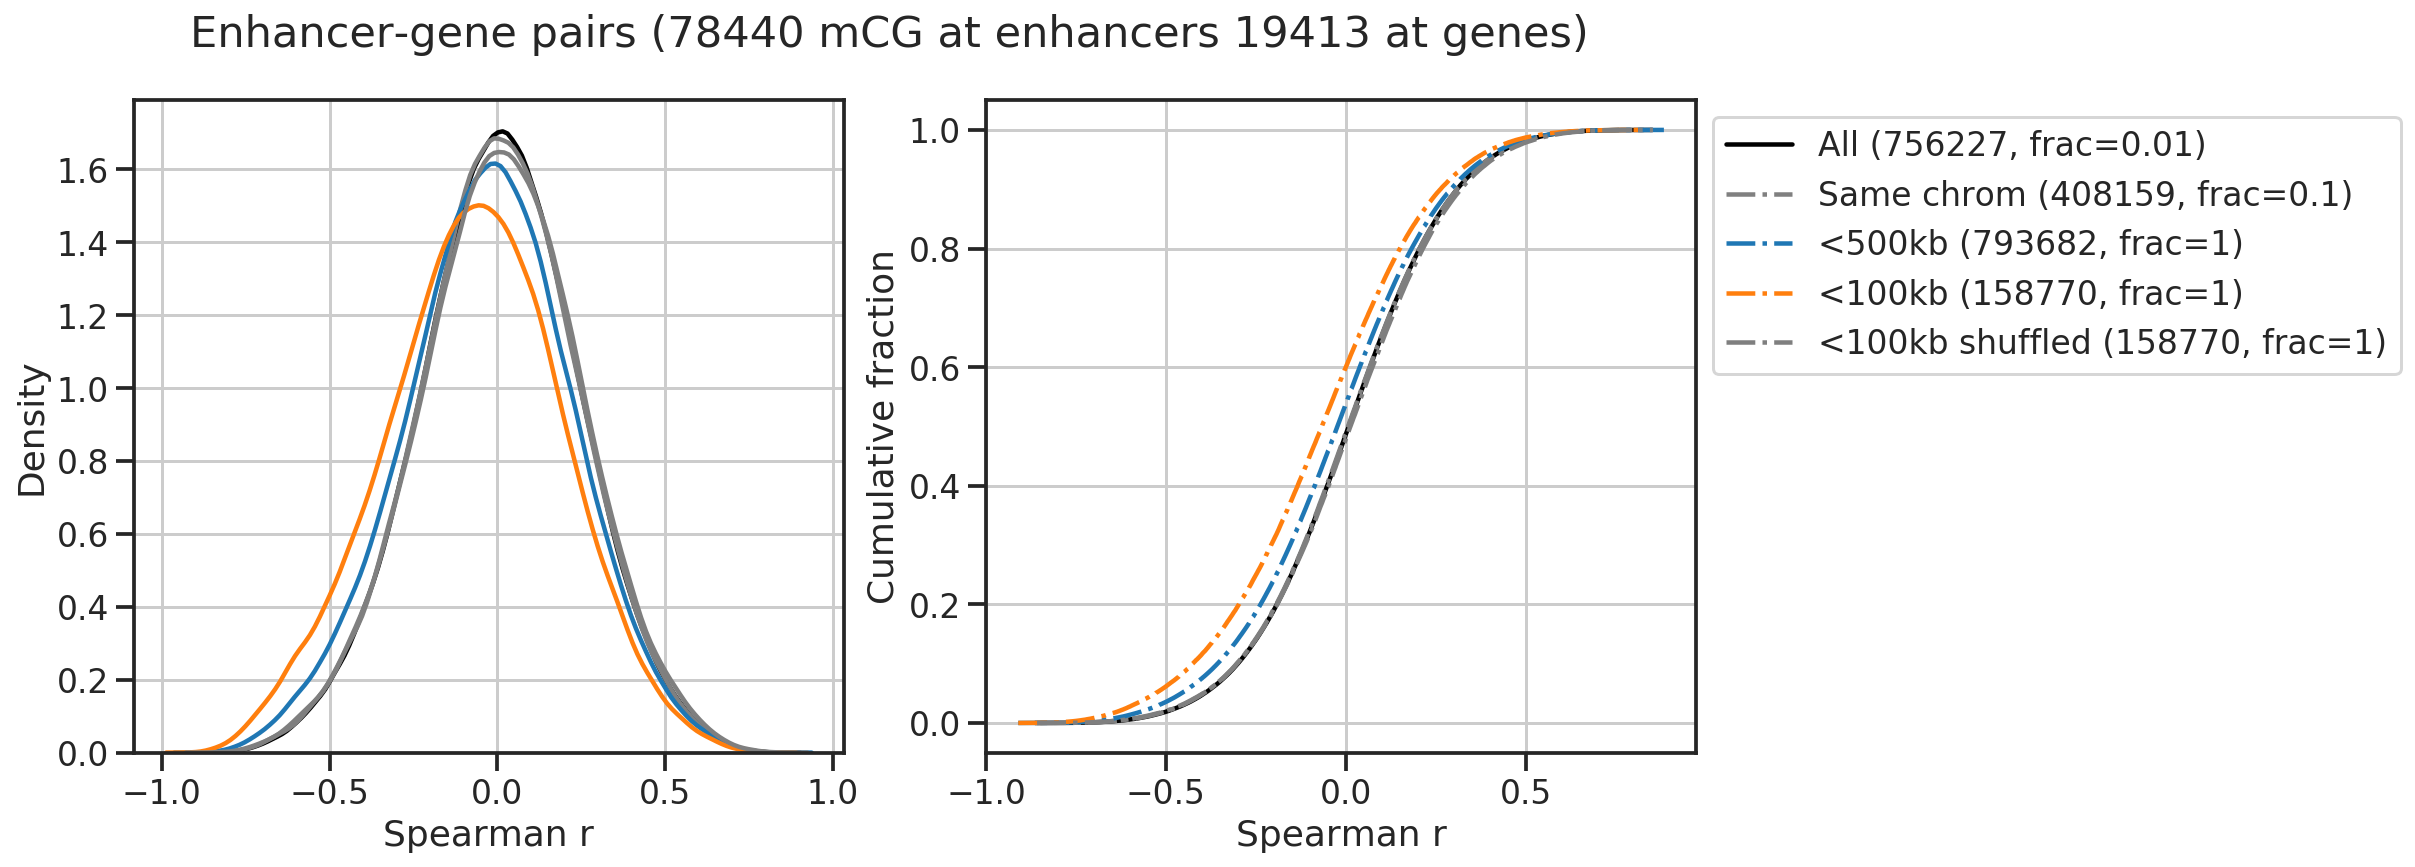

In [203]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks, labels, colors):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
#                      label='{} ({})'.format(label, len(_x)),
                     color=color,
                     hist=False,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Density')
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-.'
        if label == 'All':
            linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Cumulative fraction')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = 'distribution-different-categories' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

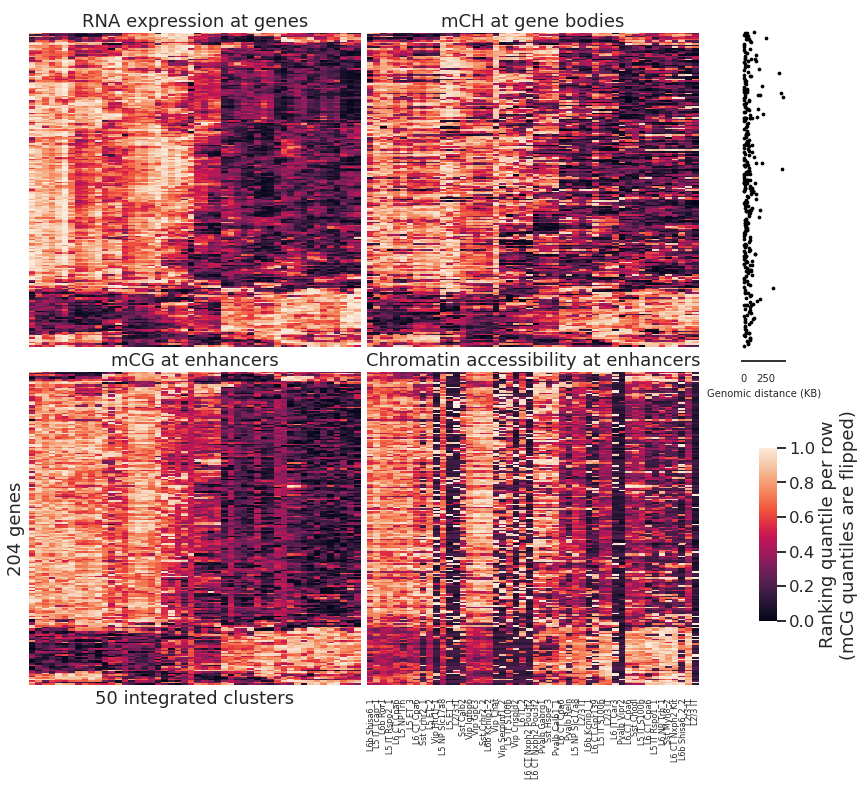

In [53]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

# back compactibility
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clst_annot.index.values])

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black')
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
#                     xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    ax = axs[0,1]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = 'heatmap-example-enhancer-genes' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

### Compare with nearest gene 

In [77]:
# get nn gene information
top_sig['nearest_gene'] = regions_info.set_index('index').loc[top_sig['ens'].values, 'gene_name'].values

n_nngenes = (top_sig['gene'] == top_sig['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes, n_pair, n_nngenes/n_pair, n_pair-n_nngenes))
    
nontr_top_sig = top_sig.loc[(top_sig['gene'] != top_sig['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig.shape)
nontr_top_sig.head()

0/319=0.00 pairs are from the nearest genes, 319 non-trivial pairs
(319, 18)


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,chr,start,end,clsts,length,chrom,center,nearest_gene
41,ENSMUSG00000074238,31322,-0.852293,441748,9.214888e-07,0.029482,0.014241,0.008467,Ap1ar,31322,chr3,127395259,127396291,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,2_3_1,3_1_1,3_2_...",1032,3,127395775,Ank2
53,ENSMUSG00000002107,12544,-0.845186,426465,1.856566e-06,0.039417,0.018581,0.010746,Celf2,12544,chr2,7082278,7083919,"1_1_1,2_1_1,2_1_2,2_2_1,2_3_1,3_1_1,3_1_2,3_2_...",1641,2,7083098,Celf2
7,ENSMUSG00000037855,90809,-0.879184,420640,0.000000e+00,0.000000,0.000000,0.000000,Zfp365,90809,chr10,67491359,67492685,"1_1_1,1_2_1,1_2_2,2_1_1,2_3_1,3_1_1,3_1_2,3_2_...",1326,10,67492022,Egr2
64,ENSMUSG00000026202,4244,-0.842017,389827,2.273560e-06,0.040570,0.018941,0.010903,Tuba4a,4244,chr1,74829644,74830433,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,2_3_1,3_1_1,3_2_...",789,1,74830038,Cdk5r2
35,ENSMUSG00000112730,87423,-0.855654,330859,4.792225e-07,0.018145,0.008826,0.005396,4930567K20Rik,87423,chr10,11079520,11080058,"4_1_1,4_2_1",538,10,11079789,Grm1


In [49]:
# nontr_top_sig.groupby('gene').size().sort_values(ascending=False)

In [50]:
# browser link
for j, (i, row) in enumerate(nontr_top_sig.iterrows()):
    if j > 30:
        break
    print(row['gene'], snmcseq_utils.gen_annoj_url(row['chrom'], row['center'], 30, file='index_Ens100_Fangming.html'))


ENSMUSG00000074238 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=3&position=127395775&bases=30
ENSMUSG00000002107 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=2&position=7083098&bases=30
ENSMUSG00000037855 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=10&position=67492022&bases=30
ENSMUSG00000026202 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=1&position=74830038&bases=30
ENSMUSG00000112730 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=10&position=11079789&bases=30
ENSMUSG00000008575 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=4&position=82459682&bases=30
ENSMUSG00000056486 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=2&position=73987998&bases=30
ENSMUSG00000007656 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.h

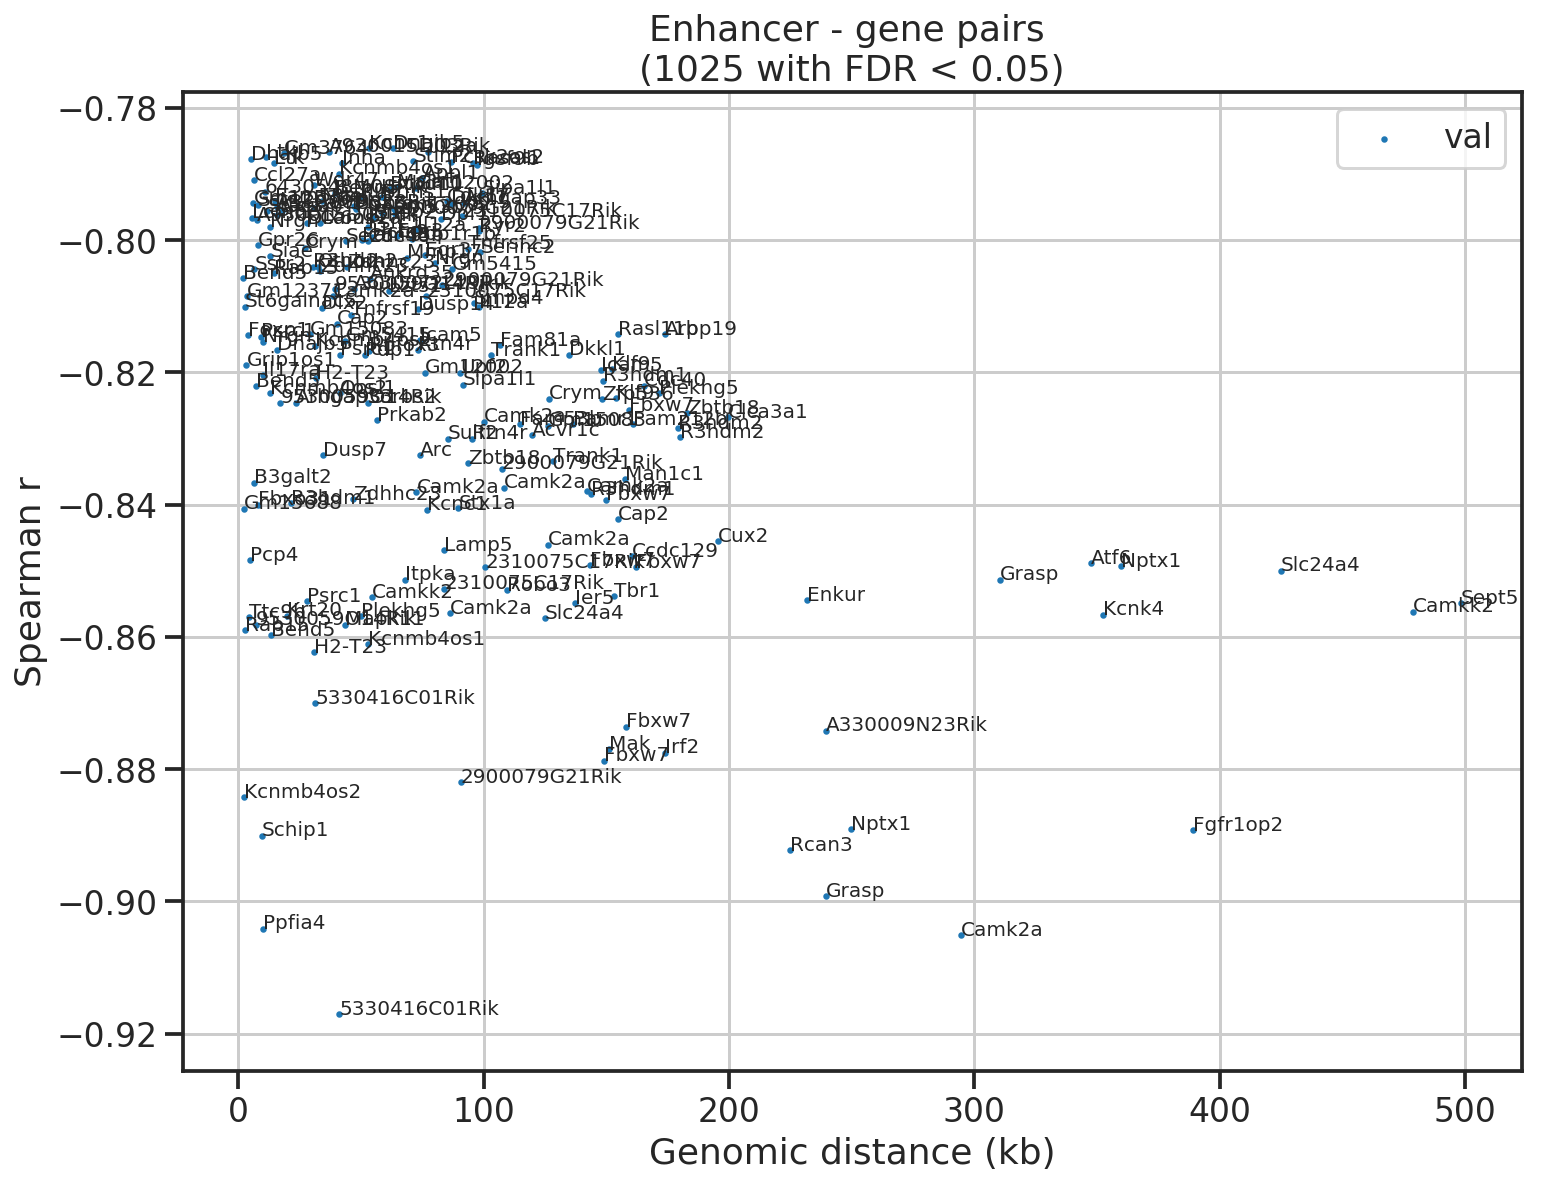

In [50]:
# vals 
scale = 1.5
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8*scale,6*scale))
        
#     # plot mean
#     ax.plot(
#         _dist, _mval,
#         c='gray',
#         label='Mean level (n_bins={})'.format(n),
#     )
    
    # plot significant 
    _df = nontr_top_sig 
    ax.scatter(_df['dist']/1000, _df['val'], s=3)
        
    # plot significant 
    _df = nontr_top_sig 
    texts = []
    for idx, row in _df.iterrows():
        texts.append(
            ax.text(
                row['dist']/1000, 
                row['val'], 
                "{}".format(row['gene']),
                fontsize=10,
        ))
#     adjust_text(texts) 
    
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel('Genomic distance (kb)')
    ax.set_ylabel('Spearman r')
    ax.set_title('Enhancer - gene pairs \n({} with FDR < 0.05)'.format(len(top_sig)))
    output_name = '27-example-enhancer-genes' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()
    


### Compare with CICERO findings 

In [51]:
# CICERO enhancers -> genes
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/ref/cicero_enhancer_gene_mm10_nochr.bed'
cicero_to_gene = pd.read_csv(f, sep='\t', header=None, names=['chrom', 'start', 'end', 'index', 'gene'])
cicero_to_gene['chrom'] = cicero_to_gene['chrom'].apply(lambda x: 'chr'+str(x))
print(cicero_to_gene.shape)
cicero_to_gene.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1283006, 5)


,chrom,start,end,index,gene
0,chr1,98117479,98117798,0,Pam
1,chr1,98119472,98120309,1,7SK
2,chr1,98119472,98120309,2,B230216N24Rik
3,chr1,98119472,98120309,3,Pam
4,chr1,98128413,98131088,4,B230216N24Rik


In [54]:
# enhancers -> CICERO enhancers 
f = '/cndd2/fangming/scf_enhancers/enhancer_round3_191128/results/enhancer_cicero_overlap.bed'
ens_to_cicero = pd.read_csv(f, sep="\t", header=None, 
                            names=['chrom', 'start', 'end', 'name', 
                                    'chrom_cicero', 'start_cicero', 'end_cicero', 'overlap'
                                   ])
print(ens_to_cicero.shape)
ens_to_cicero.head()


(76418, 8)


,chrom,start,end,name,chrom_cicero,start_cicero,end_cicero,overlap
0,chr1,3361059,3361196,"4_2_1,5_1_2,6_1_1",chr1,3360703,3361427,137
1,chr1,3369768,3369974,"3_2_1,5_1_1,5_1_2",chr1,3369351,3369979,206
2,chr1,3371656,3371972,"4_1_1,4_2_1",chr1,3371595,3372020,316
3,chr1,3395423,3395719,5_1_1,chr1,3395318,3395765,296
4,chr1,3399093,3399372,"1_1_1,1_2_1",chr1,3399000,3401001,279


In [55]:
# enhancers -> cicero enhancers -> cicero_genes # long, a few minutes
_cicero = cicero_to_gene.set_index(['chrom', 'start', 'end'])
def get_gene_from_cicero(row, cicero):
    """
    """
    chrom, start, end = row[['chrom_cicero', 'start_cicero', 'end_cicero']].tolist()
    genes = cicero.loc[(chrom, start, end), 'gene'].values
    return genes
    
ens_to_cicero['gene_cicero'] = ens_to_cicero.apply(lambda x: get_gene_from_cicero(x, _cicero), axis=1)
print(ens_to_cicero.shape)
ens_to_cicero.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


(76418, 9)


,chrom,start,end,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero
0,chr1,3361059,3361196,"4_2_1,5_1_2,6_1_1",chr1,3360703,3361427,137,"[Gm1992, Xkr4]"
1,chr1,3369768,3369974,"3_2_1,5_1_1,5_1_2",chr1,3369351,3369979,206,"[Gm1992, Xkr4]"
2,chr1,3371656,3371972,"4_1_1,4_2_1",chr1,3371595,3372020,316,[Xkr4]
3,chr1,3395423,3395719,5_1_1,chr1,3395318,3395765,296,[Xkr4]
4,chr1,3399093,3399372,"1_1_1,1_2_1",chr1,3399000,3401001,279,[Xkr4]


In [73]:
# Compare with our prediction
top_sig_chr = top_sig.copy() 
top_sig_chr['chrom'] = top_sig_chr['chrom'].apply(lambda x: 'chr'+str(x))

comp_cicero = pd.merge(top_sig_chr, ens_to_cicero, on=['chrom', 'start', 'end'])
print(top_sig_chr.shape, ens_to_cicero.shape, comp_cicero.shape)
comp_cicero.head()

(319, 17) (76418, 9) (286, 23)


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,...,clsts,length,chrom,center,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero
0,ENSMUSG00000028944,44640,-0.910492,15219,0.0,0.0,0.0,0.0,Prkag2,44640,...,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",1874,chr5,25085423,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",chr5,25084829,25085558,729,"[1500035N22Rik, 2900005J15Rik, 7SK, AC116151.1..."
1,ENSMUSG00000028944,44640,-0.910492,15219,0.0,0.0,0.0,0.0,Prkag2,44640,...,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",1874,chr5,25085423,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",chr5,25086212,25087586,148,"[1500035N22Rik, 2900005J15Rik, Crygn, E130116L..."
2,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,...,"1_2_1,4_1_1,4_2_1",3348,chr8,84765587,"1_2_1,4_1_1,4_2_1",chr8,84764174,84764443,269,"[1700122E12Rik, 2310036O22Rik, AC161765.1, Asn..."
3,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,...,"1_2_1,4_1_1,4_2_1",3348,chr8,84765587,"1_2_1,4_1_1,4_2_1",chr8,84764821,84765426,605,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ..."
4,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,...,"1_2_1,4_1_1,4_2_1",3348,chr8,84765587,"1_2_1,4_1_1,4_2_1",chr8,84765555,84766738,1183,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ..."


In [78]:
def check_agree(row):
    """
    """
    return (row['gene_name'] in row['gene_cicero'].tolist())

###
gid_to_name = df_genes.set_index('gid')['gene_name']
def check_agree_gid(row):
    """
    """
    return (gid_to_name.loc[row['gene']] in row['gene_cicero'].tolist())
### 

comp_cicero['agree?'] = comp_cicero.apply(check_agree, axis=1)
n_genes_avg = comp_cicero['gene_cicero'].apply(len).mean()

n_overlap = len(comp_cicero)
n_agree = comp_cicero['agree?'].sum()
n_test = comp_cicero.shape[0]
print(
    "{}/{}={:.2f} enhancer-gene pairs whose enhancers overlap with CICERO enhancers, {}/{}={:.2f} of them agree with CICERO prediction."
    .format(n_overlap, n_pair, n_overlap/n_pair, n_agree, n_test, n_agree/n_test))

comp_cicero[comp_cicero['agree?']].head()

286/319=0.90 enhancer-gene pairs whose enhancers overlap with CICERO enhancers, 212/286=0.74 of them agree with CICERO prediction.


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,...,length,chrom,center,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero,agree?
0,ENSMUSG00000028944,44640,-0.910492,15219,0.0,0.0,0.0,0.0,Prkag2,44640,...,1874,chr5,25085423,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",chr5,25084829,25085558,729,"[1500035N22Rik, 2900005J15Rik, 7SK, AC116151.1...",True
1,ENSMUSG00000028944,44640,-0.910492,15219,0.0,0.0,0.0,0.0,Prkag2,44640,...,1874,chr5,25085423,"1_1_1,1_2_1,2_1_1,2_1_2,2_2_1,3_1_1,3_1_2,3_2_...",chr5,25086212,25087586,148,"[1500035N22Rik, 2900005J15Rik, Crygn, E130116L...",True
2,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,...,3348,chr8,84765587,"1_2_1,4_1_1,4_2_1",chr8,84764174,84764443,269,"[1700122E12Rik, 2310036O22Rik, AC161765.1, Asn...",True
3,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,...,3348,chr8,84765587,"1_2_1,4_1_1,4_2_1",chr8,84764821,84765426,605,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ...",True
4,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0,Nfix,74666,...,3348,chr8,84765587,"1_2_1,4_1_1,4_2_1",chr8,84765555,84766738,1183,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ...",True


### nearest genes vs CICERO? 

- significant genes
- nearest genes
- agreed with cicero

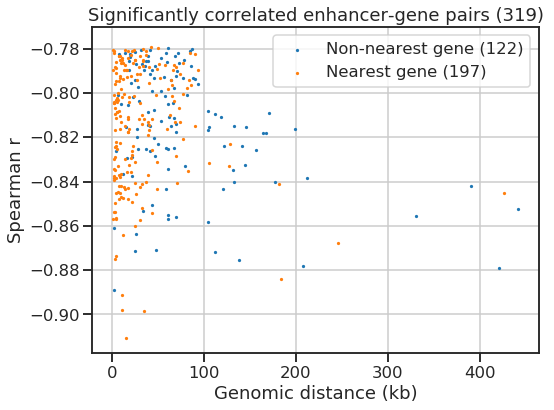

In [79]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

# plot sig 
_df = top_sig[top_sig['gene_name']!=top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C0',
    alpha=1,
    label='Non-nearest gene ({})'.format(n),
)

# explained by nearest genes
# plot sig 
_df = top_sig[top_sig['gene_name']==top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C1',
    alpha=1,
    label='Nearest gene ({})'.format(n),
)


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()



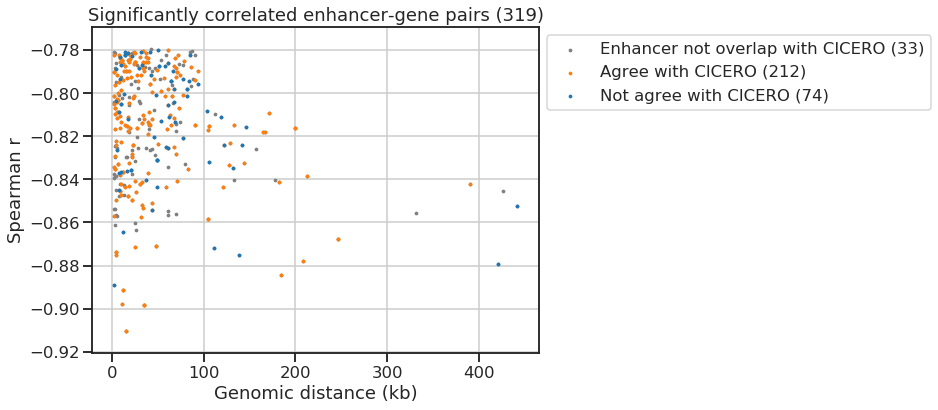

In [80]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

s = 5 
# plot sig 
_df = top_sig 
n = len(_df) - len(comp_cicero)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='grey',
    alpha=1,
    label='Enhancer not overlap with CICERO ({})'.format(n),
)

# agree
_df = comp_cicero[comp_cicero['agree?']]
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='C1',
    alpha=1,
    label='Agree with CICERO ({})'.format(n),
)

# not agree
_df = comp_cicero[~comp_cicero['agree?']]
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='C0',
    alpha=1,
    label='Not agree with CICERO ({})'.format(n),
)

ax.legend(bbox_to_anchor=(1,1))

ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()


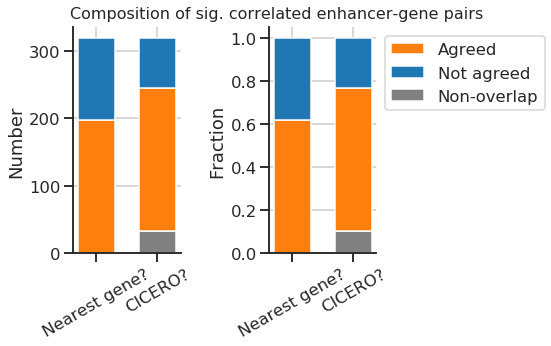

In [84]:
# numbers 
track1 = [0, 
          len(top_sig[top_sig['gene_name']==top_sig['nearest_gene']]), 
          len(top_sig[top_sig['gene_name']!=top_sig['nearest_gene']]),
         ]
track1_colors = ['C1', 'C0']
track1_labels = ['Agreed', 'Not agreed']
track2 = [0,
          len(top_sig) - len(comp_cicero), 
          len(comp_cicero[comp_cicero['agree?']==True]),
          len(comp_cicero[comp_cicero['agree?']==False]),
         ]
track2_colors = ['grey', 'C1', 'C0']
track2_labels = ['Non-overlap', 'Agreed', 'Not agreed']

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,5))
    ax = axs[0]
    for i in range(len(track1)-1):
        color = track1_colors[i]
        ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
    for i in range(len(track2)-1):
        color = track2_colors[i]
        ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    ax.set_xticklabels(['', 'Nearest gene?', 'CICERO?'], rotation=30)
    ax.set_ylabel('Number')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
# plot 2 fraction 
track1 = np.array(track1)
track1 = track1/track1.sum()

track2 = np.array(track2)
track2 = track2/track2.sum()

with sns.plotting_context('talk'):
    ax = axs[1]
    for i in range(len(track1)-1):
        color = track1_colors[i]
        ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])

    for i in range(len(track2)-1):
        color = track2_colors[i]
        ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    ax.set_xticklabels(['', 'Nearest gene?', 'CICERO?'], rotation=30)
    ax.set_ylabel('Fraction')
    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    fig.suptitle('Composition of sig. correlated enhancer-gene pairs', fontsize=16)
    output_name = 'compare-to-nngenes-cicero' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    fig.tight_layout()

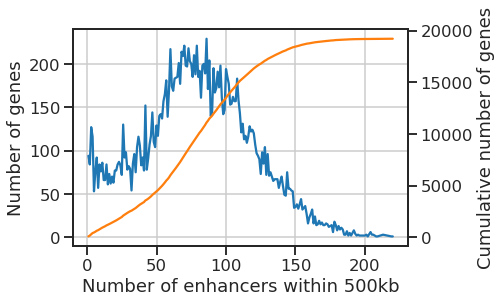

In [85]:
a = to_evals.groupby('gene').size().sort_values() #.values
a = a.value_counts().sort_index() #.values

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    ax.plot(a.index.values, a.values)
    ax.set_xlabel('Number of enhancers within 500kb')
    ax.set_ylabel('Number of genes')
    ax2 = ax.twinx()
    ax2.plot(a.index.values, np.cumsum(a.values), color='C1', label='Cumulative')
    ax2.grid(False)
    ax2.set_ylabel('Cumulative number of genes')
    
    output_name = 'distribution-num-enhancers-per-gene' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')


### super enhancers 
start from ```to_evals```
- statistics on gene - cumulative effect of enhancers

In [103]:
th = -0.3
_tmp = to_evals.groupby('gene')
gene_score = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score = gene_score.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score.sort_values('val_score').head()

,val_score,val_num
gene,,
ENSMUSG00000032530,-32.975654,112
ENSMUSG00000048285,-30.295990,120
ENSMUSG00000072679,-29.757911,115
ENSMUSG00000032528,-29.049940,110
ENSMUSG00000024617,-27.997287,105


In [104]:
_tmp = to_evals_shuffled.groupby('gene')
gene_score_shuffled = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score_shuffled = gene_score_shuffled.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score_shuffled.sort_values('val_score').head()

,val_score,val_num
gene,,
ENSMUSG00000085654,-33.807755,115
ENSMUSG00000020541,-32.866531,121
ENSMUSG00000063160,-27.804874,107
ENSMUSG00000041431,-26.008764,99
ENSMUSG00000049907,-25.306218,104


In [88]:
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1)[:30])
# sns.distplot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1))
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score_shuffled.sort_values('val').index.values)].sum(axis=1)[:100])

In [105]:
corr_tracks = np.array([
    gene_score_shuffled['val_score'].values,
    gene_score['val_score'].values,
])

labels = np.array([
    'Gene score shuffled',
    'Gene score',
])

colors = np.array([
    'C0',
    'C1',
])

subsample_rates = np.array([
    1,
    1,
])

In [112]:
# FDR
bins_eval = np.linspace(-30, 0, 1000)

# background
x_bck = np.sort(corr_tracks[0])
y_bck = np.arange(len(x_bck))/len(x_bck)

# fore-ground - 1
x_fr = np.sort(corr_tracks[1])
y_fr = np.arange(len(x_fr))/len(x_fr)

# ratio 0
fdr_multi = fdr(bins_eval, x_bck, y_bck, x_fr, y_fr)

# plt.plot(bins_eval, fdr_multi)

    

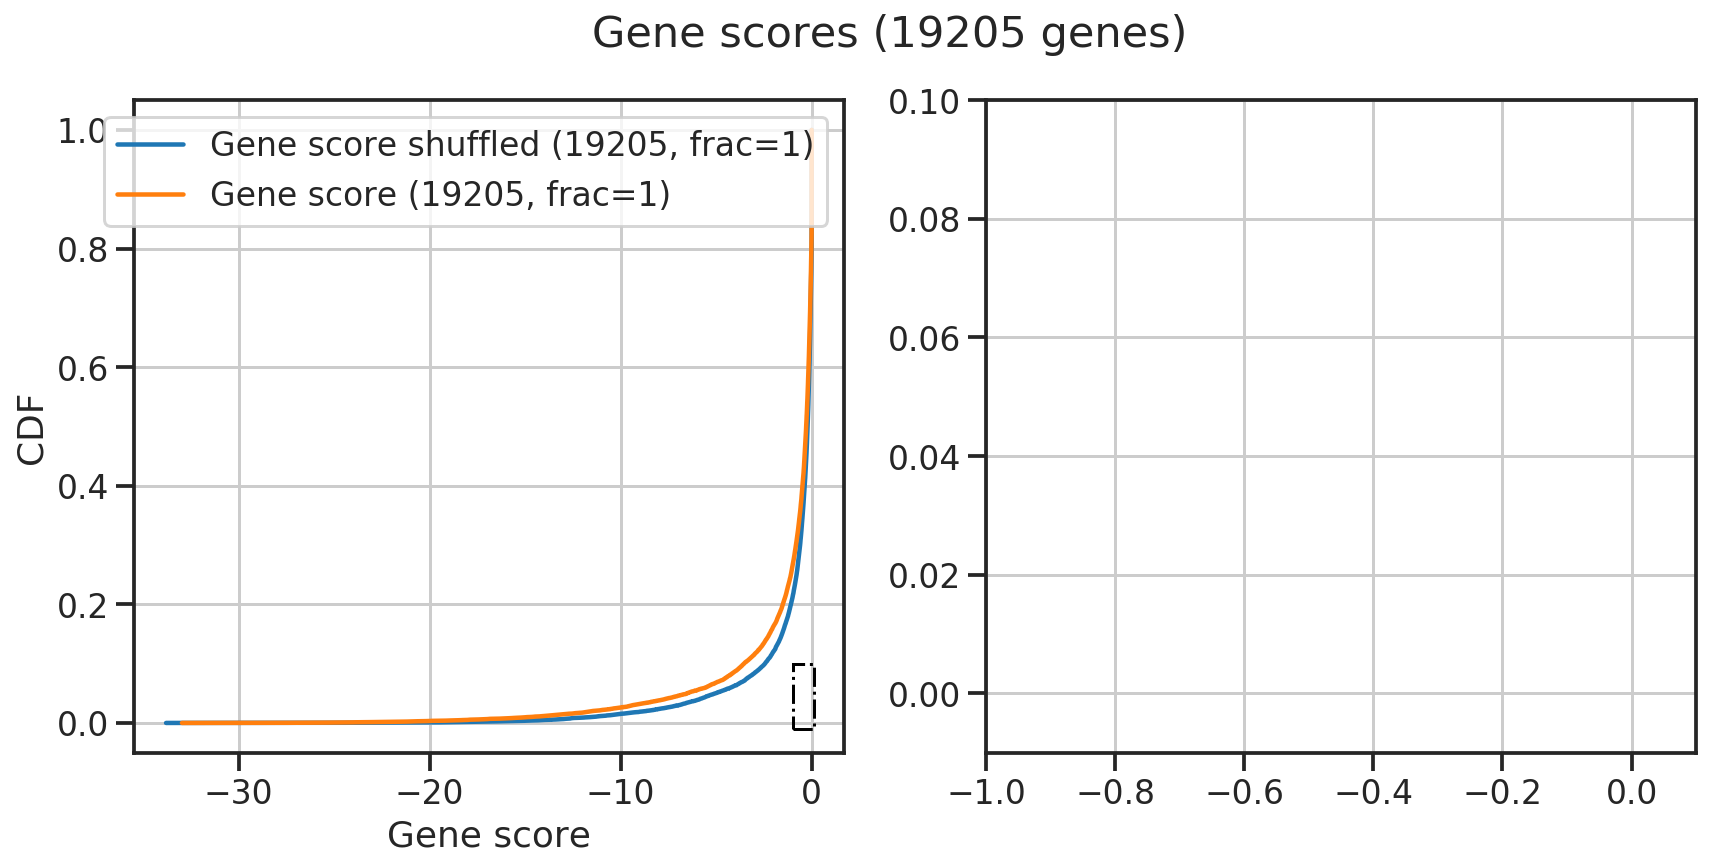

In [113]:
# plot
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('CDF')
    
    xmin, xmax, ymin, ymax = -1, 0.1, -0.01, 0.1
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    
    fig.suptitle('Gene scores ({} genes)'.format(len(gene_score)), 
                )
    
#     fig.tight_layout()
    output_name = '30-super-enhancers-score' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

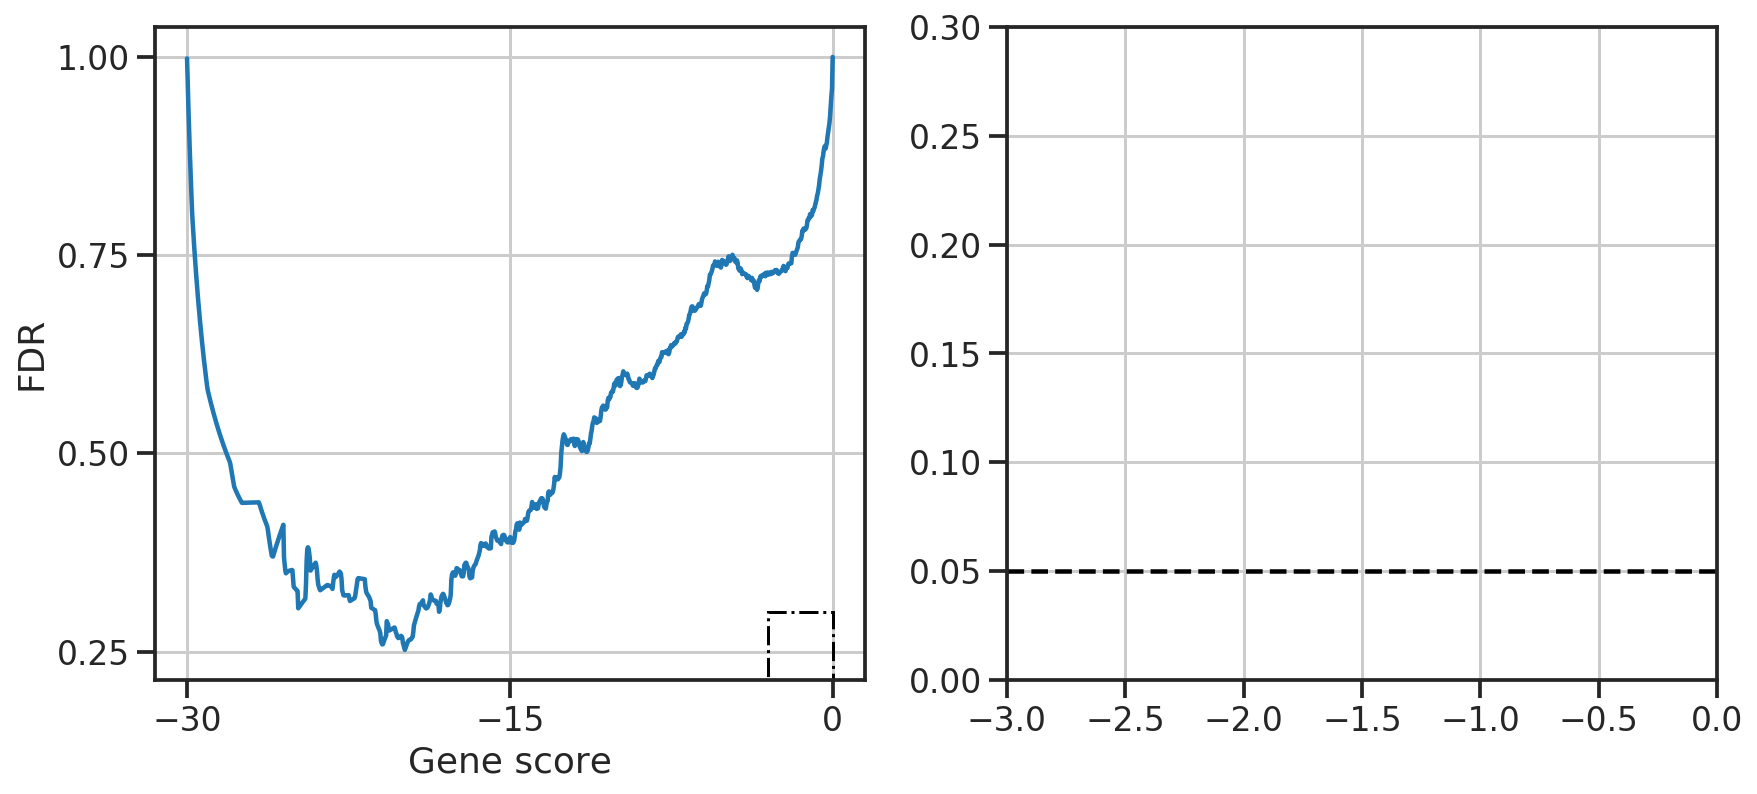

In [114]:
from matplotlib.patches import Rectangle
with sns.plotting_context('talk'):
    # inner box
#     xmin_1, xmax_1, ymin_1, ymax_1 = -0.8, 0.8, 0, 1 
    xmin, xmax, ymin, ymax = -3, 0, 0, 0.3 
    
    fig, axs = plt.subplots(1, 2, figsize=(7*2, 6*1))
    ax = axs[0]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
#     ax.set_xlim([xmin_1, xmax_1])
#     ax.set_ylim([ymin_1, ymax_1])
#     ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('FDR')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))

    ax = axs[1]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    ax.axhline(0.05, color='black', linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    output_name = '31-super-enhancers-fdrs' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [115]:
th = 0.3
gene_score['fdr'] = gene_score['val_score'].apply(lambda x: fdr(x, x_bck, y_bck, x_fr, y_fr))
res_multi = gene_score[gene_score['fdr']<th].sort_values('val_score')
print(res_multi.shape)
res_multi.head()

(30, 3)


,val_score,val_num,fdr
gene,,,
ENSMUSG00000000489,-21.224994,87,0.295845
ENSMUSG00000028785,-21.210972,119,0.289399
ENSMUSG00000022237,-21.166915,74,0.283817
ENSMUSG00000059895,-21.091116,111,0.279075
ENSMUSG00000099424,-21.024754,75,0.274360


### Lots of heatmaps 

In [116]:
th2 = -0.3
to_plot = to_evals[to_evals['val']<th2] 

In [117]:
to_plot.shape
to_plot.head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
1,ENSMUSG00000000001,30037,-0.358175,987167,0.063154,0.658572,0.523850,0.443946
3,ENSMUSG00000000001,30040,-0.510012,969326,0.016277,0.518071,0.375003,0.293285
12,ENSMUSG00000000001,30054,-0.350780,776930,0.066800,0.664369,0.530909,0.451796
19,ENSMUSG00000000001,30064,-0.354430,709522,0.064979,0.661518,0.527437,0.447917
53,ENSMUSG00000000001,30122,-0.396303,258287,0.046617,0.624649,0.485948,0.404956


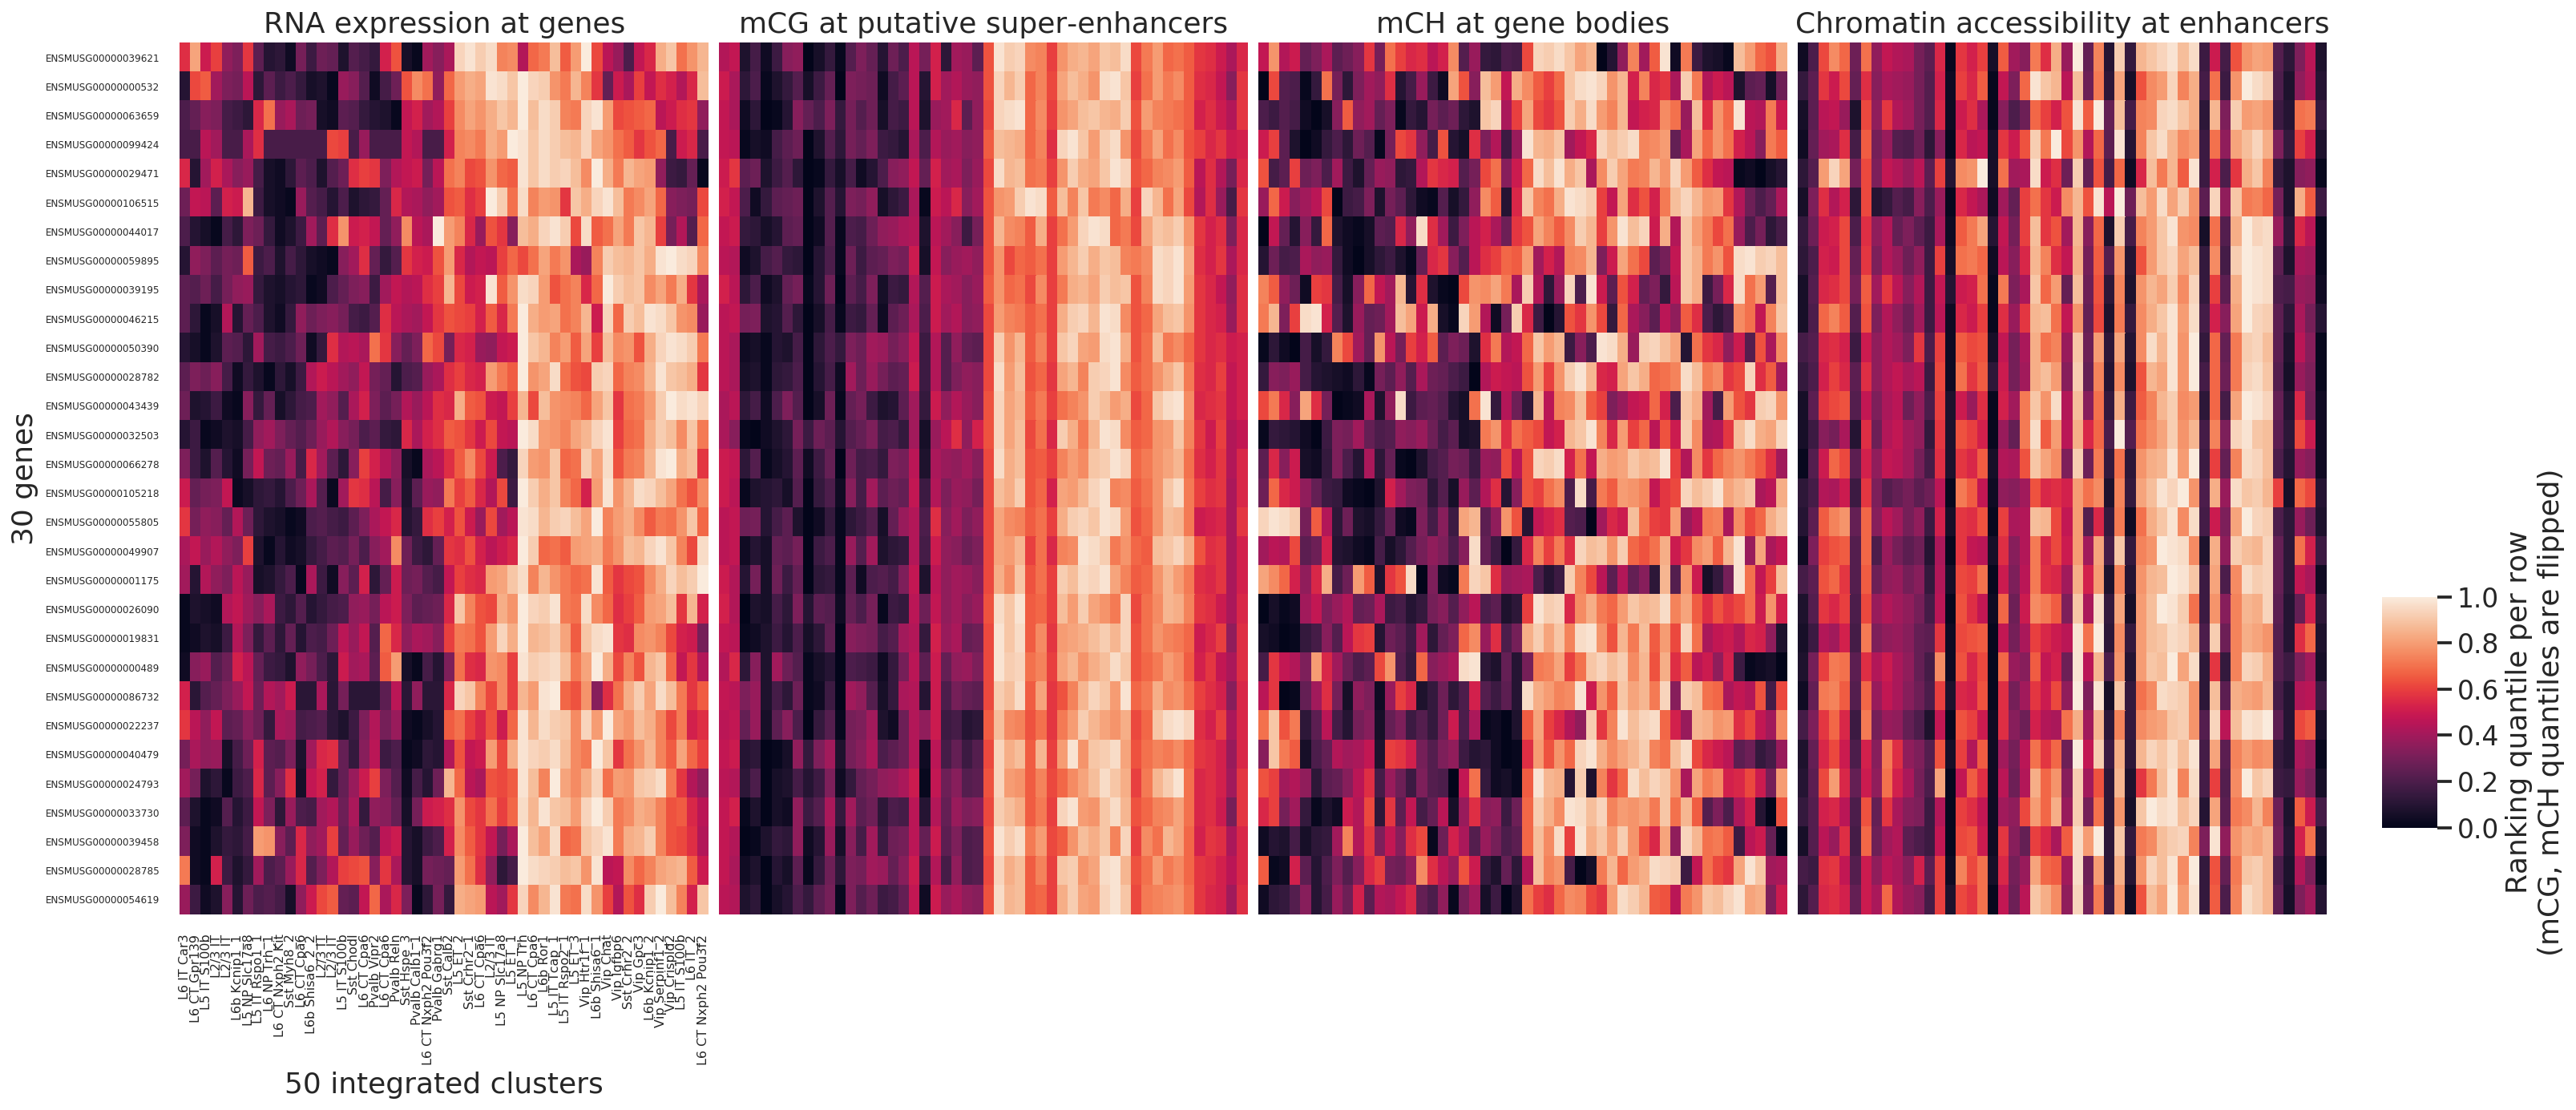

In [118]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[res_multi.index.values, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = to_plot.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(1, 4, figsize=(6*4,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    ax = axs[0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
#                     xticklabels=False,
                    yticklabels=True,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                   )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))

    ax = axs[1]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at putative super-enhancers')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[2]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']],
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[3]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
    output_name = '32-heatmap-examples-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [120]:
gene = 'Kcnc1'
gid = df_genes.groupby('gene_name').first().loc[gene, 'gid']
gid

'ENSMUSG00000058975'

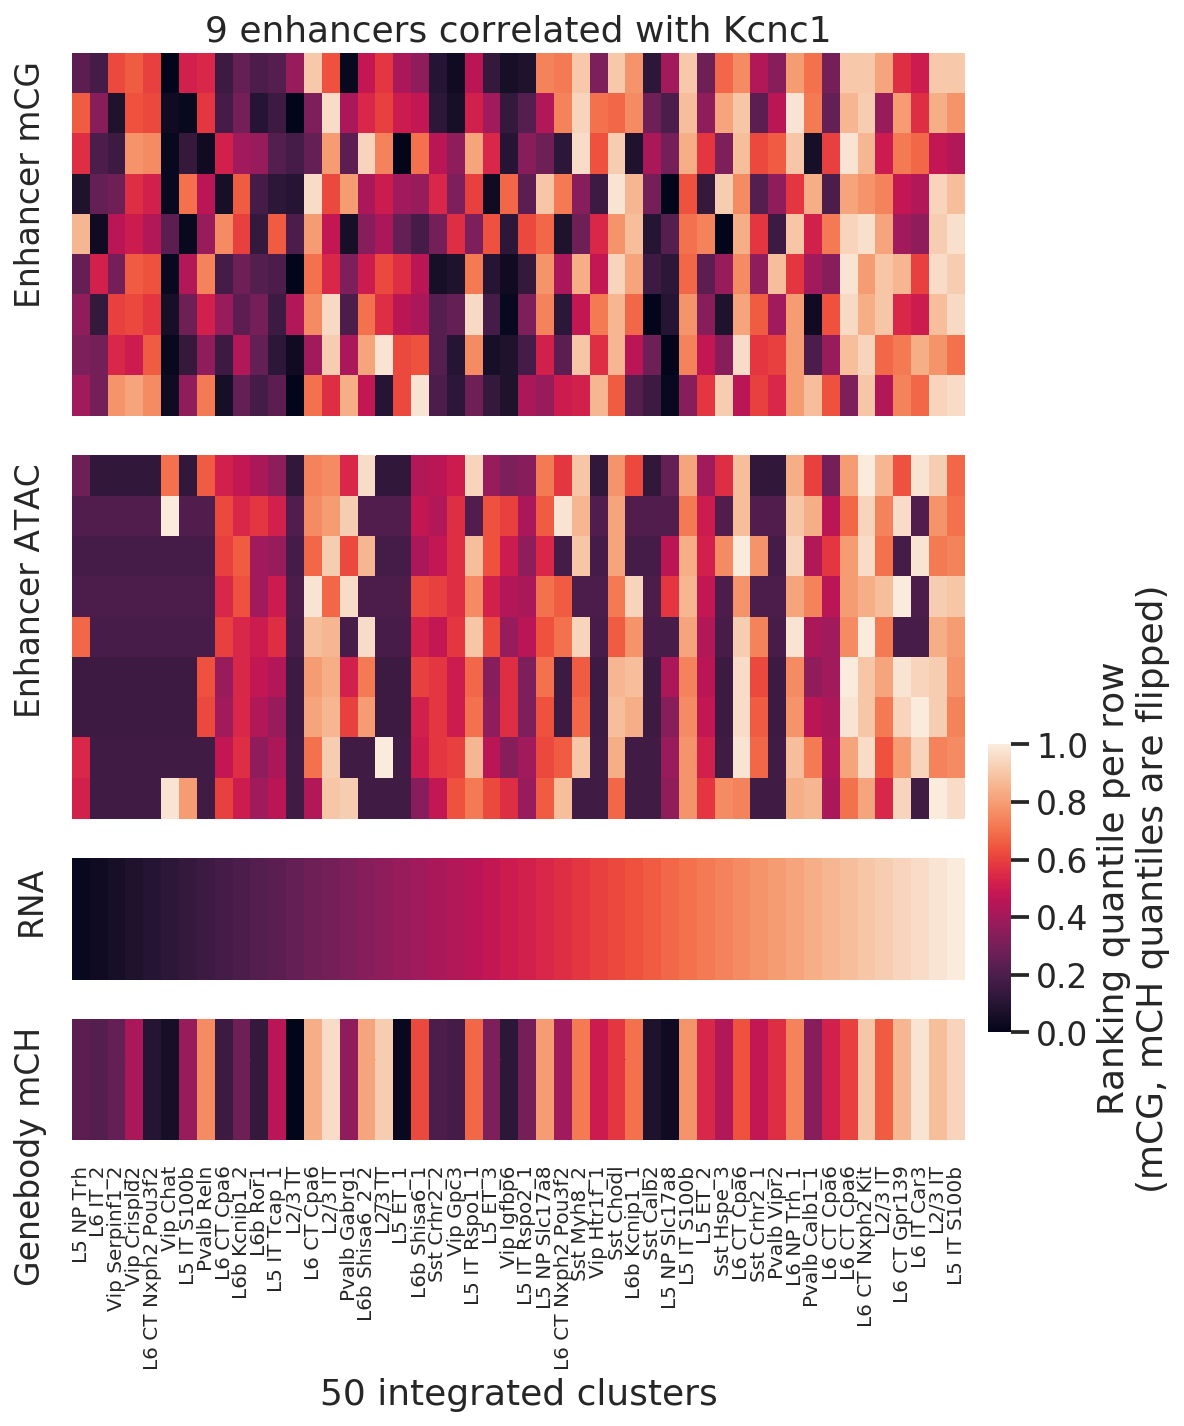

In [133]:
# heatmap of gene by cluster

cmap = 'rocket'
gene = 'Kcnc1'
gene = df_genes.groupby('gene_name').first().loc[gene, 'gid']

# rna at genes 
rna_mat = gene_rna_clsts.loc[[gene], clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)


# ordered
ens_ordered = to_plot.set_index('gene').loc[gene]
clst_idx_ordered = np.argsort(rna_mat_norm.values.flatten())

# mCH at genes
mch_mat = gene_mch_clsts.loc[[gene], clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# organize heatmap to plot
n_repeats = 3
blank_repeats = 1

heatmap_all = np.vstack([
    # mcg
    (1-mcc_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered],    
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # atac
     atac_mat.rank(axis=1, pct=True).iloc[:, clst_idx_ordered],
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # rna
    np.repeat(rna_mat_norm.iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # mch
    np.repeat((1-mch_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
])

yticklabels = np.hstack([
    ['Enhancer mCG']*(len(mcc_mat) + blank_repeats),
    ['Enhancer ATAC']*(len(atac_mat) + blank_repeats),
    ['RNA']*(n_repeats + blank_repeats),
    ['Genebody mCH']*n_repeats,
])
yticklabels = snmcseq_utils.dedup_array_elements(yticklabels)

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(8,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    g = sns.heatmap(heatmap_all, 
                    xticklabels=clusters_selected_labels[clst_idx_ordered],
                    yticklabels=yticklabels, 
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel('{} integrated clusters'.format(mcc_mat.shape[1]))
    ax.set_title('{} enhancers correlated with {}'.format(len(mcc_mat), gid_to_name.loc[gene]))
    
    output_name = '33-heatmap-1example-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.subplots_adjust(wspace=0.02, hspace=0.08)
    plt.show()

In [125]:
# bed = regions.set_index('index').loc[ens_ordered['ens'].values].reset_index()[['chrom', 'start', 'end', 'index']]
# bed.to_csv('/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/kcnc1_enhancers.tsv', 
#            sep='\t', na_rep='NA',
#            header=False, index=False, 
#           )

In [126]:
# bed['len'] = bed['end'] - bed['start']
# bed.sort_values('len').tail()

### one example correlation

In [127]:
to_evals.sort_values('val').head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
497971,ENSMUSG00000028944,44640,-0.910492,15219,0.0,0.0,0.0,0.0
21839,ENSMUSG00000001911,74666,-0.898487,34757,0.0,0.0,0.0,0.0
506547,ENSMUSG00000029094,45230,-0.898103,10929,0.0,0.0,0.0,0.0
1076910,ENSMUSG00000057880,134049,-0.891188,11744,0.0,0.0,0.0,0.0
1421989,ENSMUSG00000106515,33115,-0.888980,2204,0.0,0.0,0.0,0.0


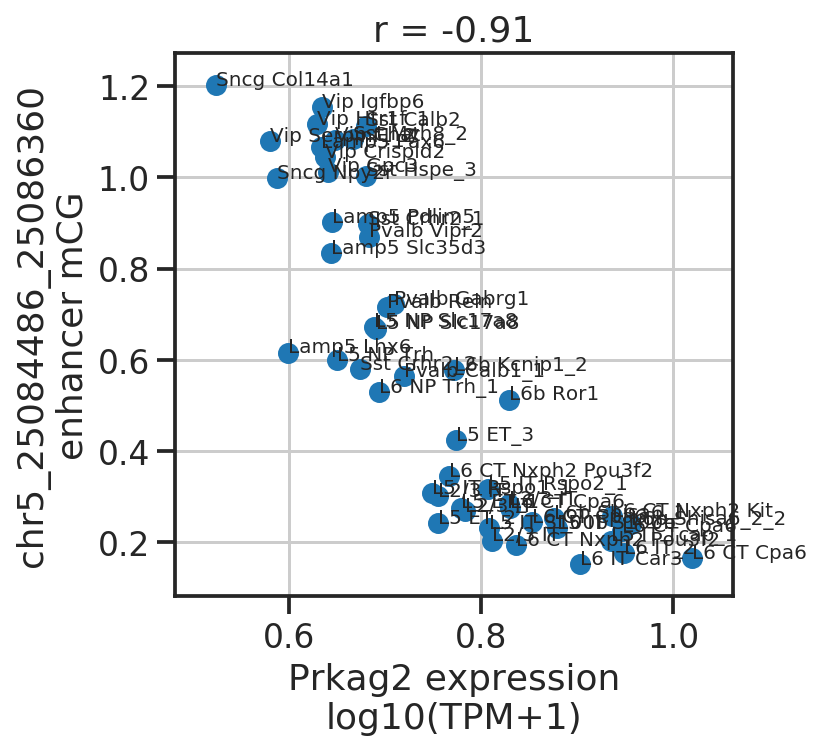

In [132]:

gene = 'ENSMUSG00000028944'
enh = 44640
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())

# gene = df_genes.groupby('gene_name').first().loc[gene, 'gid']
# gene = 'Slc1a2'
# enh = 73274
# enh_name = 'chr'+'_'.join(regions.set_index('index').loc[enh].astype(str).tolist())


_x = gene_rna_clsts.loc[gene, clusters_selected]
_y = enh_mcg_clsts.loc[enh, clusters_selected]
_c = pd.Series(clst_annot)[clusters_selected]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(_x.values, _y.values)
r, p = stats.spearmanr(_x.values, _y.values)
ax.set_title('r = {:.2f}'.format(r))
for __x, __y, __c in zip(_x, _y, _c):
    ax.text(__x, __y, __c)
ax.set_ylabel('{}\nenhancer mCG'.format(enh_name))
ax.set_xlabel('{} expression\nlog10(TPM+1)'.format(gid_to_name.loc[gene]))

output_name = '34_example_corr' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

### linear model

In [ ]:
import statsmodels.api as sm
from sklearn import metrics

set_n_enhs = 10
alphas = [1e-2, 1e-3, 1e-4, 1e-5]
r2_linears = {}
r2_linears_shuffled = {}

for alpha in alphas:
    r2_linear = []
    # for each gene build a linear model
    for i, (gene, df_sub) in enumerate(to_evals.groupby('gene')):
        if i % 1000 == 0:
            print(i)

        enss = df_sub.sort_values('dist').head(set_n_enhs)['ens'].values
        y = gene_rna_clsts.loc[gene]
        X = pd.concat([enh_mcg_clsts.loc[enss].T, enh_atac_clsts.loc[enss].T], axis=1)
        n_enhs = int(X.shape[1]/2)

        X['const'] = 1
        # linear model
        res = sm.OLS(y.values, X.values).fit_regularized(alpha=alpha)
#         r2 = res.rsquared
        r2 = metrics.r2_score(y.values, res.predict())
        r2_linear.append({'gene': gene, 
                          'n_enhs': n_enhs,
                          'r2': r2, 
                         })
    r2_linear = pd.DataFrame(r2_linear) 
    r2_linears[alpha] = r2_linear

    r2_linear_shuffled = []
    # for each gene build a linear model
    for i, (gene, df_sub) in enumerate(to_evals_shuffled.groupby('gene')):
        if i % 1000 == 0:
            print(i)

        enss = df_sub.sort_values('dist').head(set_n_enhs)['ens'].values
        y = gene_rna_clsts.loc[gene]
        X = pd.concat([enh_mcg_clsts.loc[enss].T, enh_atac_clsts.loc[enss].T], axis=1)
        n_enhs = int(X.shape[1]/2)

        X['const'] = 1
        # linear model
        res = sm.OLS(y.values, X.values).fit_regularized(alpha=alpha)
#         r2 = res.rsquared
        r2 = metrics.r2_score(y.values, res.predict())
        r2_linear_shuffled.append({'gene': gene, 
                          'n_enhs': n_enhs,
                          'r2': r2, 
                         })
    r2_linear_shuffled = pd.DataFrame(r2_linear_shuffled) 
    r2_linears_shuffled[alpha] = r2_linear_shuffled


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000


In [ ]:
list(r2_linears.keys())

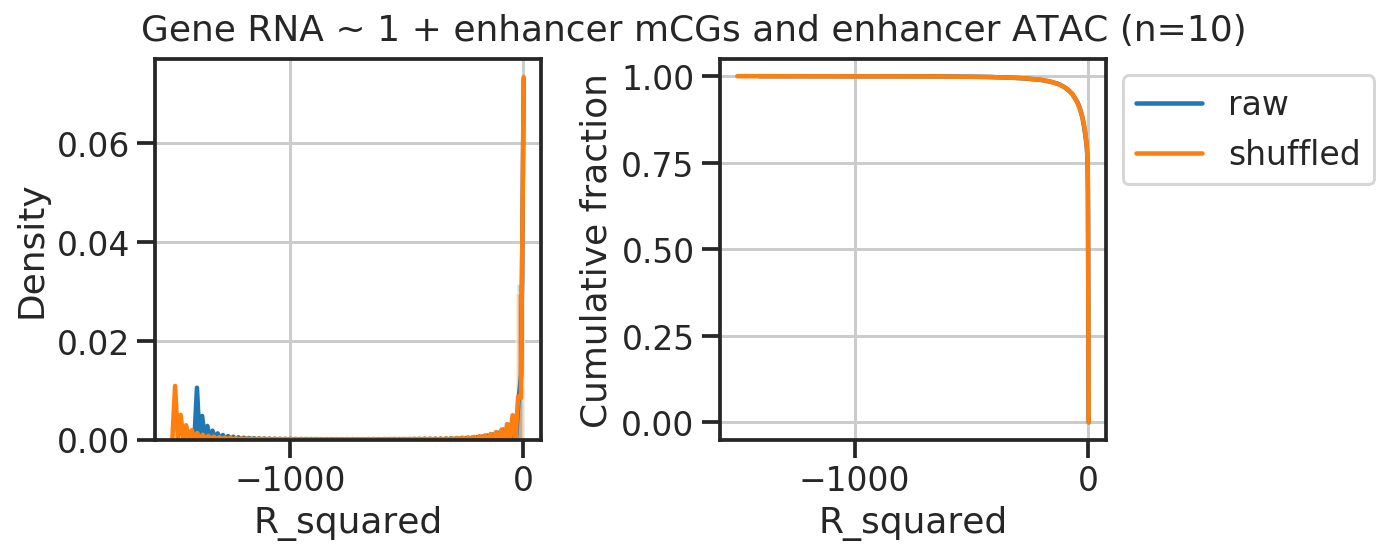

In [234]:
r2_linear = r2_linears[0.1]
r2_linear_shuffled = r2_linears_shuffled[0.1]

fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))
ax = axs[0]
sns.distplot(r2_linear['r2'], ax=ax, label='raw')
sns.distplot(r2_linear_shuffled['r2'], ax=ax, label='shuffled')
ax.set_ylabel('Density')
ax.set_xlabel('R_squared')

ax = axs[1]
snmcseq_utils.gen_cdf(r2_linear['r2'].values, flip=True, ax=ax, label='raw')
snmcseq_utils.gen_cdf(r2_linear_shuffled['r2'].values, flip=True, ax=ax, label='shuffled')
ax.set_ylabel('Cumulative fraction')
ax.set_xlabel('R_squared')
ax.legend(bbox_to_anchor=(1,1))

fig.suptitle("Gene RNA ~ 1 + enhancer mCGs and enhancer ATAC (n=10)", fontsize=18)
fig.tight_layout()
fig.savefig(output_figures.format('liear_model_gene_mCH', 'pdf'))
plt.show()

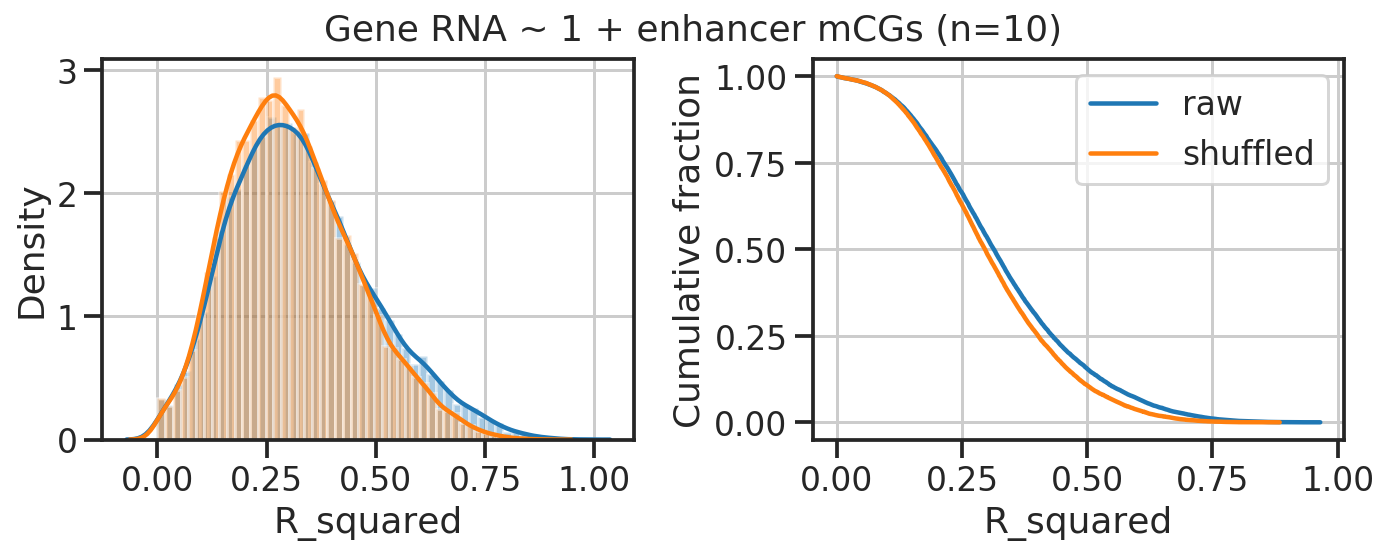

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))
ax = axs[0]
sns.distplot(r2_linear['r2'], ax=ax, label='raw')
sns.distplot(r2_linear_shuffled['r2'], ax=ax, label='shuffled')
ax.set_ylabel('Density')
ax.set_xlabel('R_squared')

ax = axs[1]
snmcseq_utils.gen_cdf(r2_linear['r2'].values, flip=True, ax=ax, label='raw')
snmcseq_utils.gen_cdf(r2_linear_shuffled['r2'].values, flip=True, ax=ax, label='shuffled')
ax.set_ylabel('Cumulative fraction')
ax.set_xlabel('R_squared')
ax.legend(bbox_to_anchor=(1,1))

fig.suptitle("Gene RNA ~ 1 + enhancer mCGs (n=10)", fontsize=18)
fig.tight_layout()
fig.savefig(output_figures.format('liear_model_gene_mCH', 'pdf'))
plt.show()